In [1]:
import os
from typing import Any, Dict, Literal, Optional, Tuple

import joblib
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import sidetable as stb
from catboost import CatBoostClassifier, Pool
from IPython.display import HTML, display
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    train_test_split,
)
from sklearn.utils.class_weight import compute_class_weight

In [2]:
def add_engineered_features(df: pd.DataFrame, inplace: bool = False) -> pd.DataFrame:
    """
    Add engineered features for GBDT models to a copy of the input DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Original Bank Marketing DataFrame.
    inplace : bool, optional
        If True, modify the input df in-place. If False (default), return modified copy.

    Returns
    -------
    pd.DataFrame
        DataFrame with added features.
    """
    if not inplace:
        df = df.copy()

    # === Age binning ===
    df["age_group"] = pd.cut(
        df["age"],
        bins=[0, 30, 55, np.inf],  # cover all realistic ages
        labels=["young", "middle", "senior"],
        include_lowest=True,
    )

    # === Education × Marital cross-feature ===
    df["education_marital"] = (
        df["education"].astype(str) + "_" + df["marital_status"].astype(str)
    )

    # === Interest spread: CPI - Euribor ===
    df["interest_diff"] = df["cons_price_index"] - df["euri_3_month"]

    # === Month + weekday combined ===
    df["month_weekday"] = df["month"].astype(str) + "_" + df["week_day"].astype(str)

    # === Interest pressure ratio ===
    df["interest_pressure_ratio"] = df["cons_price_index"] / (df["euri_3_month"] + 1e-3)

    # === Log features (avoid skew) ===
    df["log_duration"] = np.log1p(df["last_contact_duration"])

    # === Month → Season mapping ===
    month_to_season = {
        "mar": "spring",
        "apr": "spring",
        "may": "spring",
        "jun": "summer",
        "jul": "summer",
        "aug": "summer",
        "sep": "autumn",
        "oct": "autumn",
        "nov": "autumn",
        "dec": "winter",
        "jan": "winter",
        "feb": "winter",
    }
    df["season"] = df["month"].map(month_to_season)

    # === Loan burden score ===
    df["loan_burden_score"] = (df["housing_loan"] == "yes").astype(int) + (
        df["personal_loan"] == "yes"
    ).astype(int)

    # === Volatility index ===
    df["volatility_score"] = (
        df["emp_var_rate"].abs()
        + df["cons_conf_index"].abs()
        + df["euri_3_month"].abs()
    )

    return df


def split_data(
    X: pd.DataFrame,
    y: pd.Series,
    val_size: float = 0.1,
    test_size: float = 0.1,
    random_state: int = 42,
    use_stratification: bool = False,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Split input data into train, validation, and test sets, optionally using stratification.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series
        Target variable.
    val_size : float, optional
        Proportion of the data to include in the validation set, by default 0.1.
    test_size : float, optional
        Proportion of the data to include in the test set, by default 0.1.
    random_state : int, optional
        Random seed for reproducible splits, by default 42.
    use_stratification : bool, optional
        If True, data splits will be stratified using the target variable. By default False.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]
        A tuple containing:
        - X_train: pd.DataFrame
            Training feature matrix
        - X_val: pd.DataFrame
            Validation feature matrix
        - X_test: pd.DataFrame
            Test feature matrix
        - y_train: pd.Series
            Training target vector
        - y_val: pd.Series
            Validation target vector
        - y_test: pd.Series
            Test target vector

    Raises
    ------
    ValueError
        If the sum of val_size and test_size is greater than or equal to 1.
    """
    # Check that the requested splits are valid
    if val_size + test_size >= 1:
        raise ValueError("val_size + test_size must be less than 1.")

    # Determine stratification parameters
    stratify_test = y if use_stratification else None

    # First split off the test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_test,  # stratify if specified
    )

    # Adjust val_size proportion relative to the remaining data after removing test
    adjusted_val_size = val_size / (1 - test_size)

    # For the second split (train/val), stratify on the reduced dataset if needed
    stratify_val = y_temp if use_stratification else None

    # Split the remaining data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=adjusted_val_size,
        random_state=random_state,
        stratify=stratify_val,  # stratify if specified
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


def plot_table_stats(df, feature, title, rotation=0):
    no = df[df["target"] == "no"].stb.freq(
    [feature], style=False
    )
    yes = df[df["target"] == "yes"].stb.freq(
        [feature], style=False
    )

    no["target"] = "No"
    yes["target"] = "Yes"

    df_combined = pd.concat([no, yes], ignore_index=True)

    df_pivot = df_combined.pivot(
        index=feature, columns="target", values="percent"
    )

    ax = df_pivot.plot(kind="bar", figsize=(6, 4), width=0.7)

    ax.set_ylabel("Percentage (%)")
    ax.set_title(f"{title} Distribution by Target")
    ax.legend(title="Target", loc="best")
    plt.xticks(rotation=rotation)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

In [3]:
df = pd.read_csv("bank_dataset (3) (1) (1) (3) (1) (2) (1) (1) (1).csv")

In [4]:
df.head()

,age,occupation,marital_status,education,has_credit,housing_loan,personal_loan,contact_mode,month,week_day,...,contacts_per_campaign,N_last_days,nb_previous_contact,previous_outcome,emp_var_rate,cons_price_index,cons_conf_index,euri_3_month,nb_employees,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    41188 non-null  int64  
 1   occupation             41188 non-null  object 
 2   marital_status         41188 non-null  object 
 3   education              41188 non-null  object 
 4   has_credit             41188 non-null  object 
 5   housing_loan           41188 non-null  object 
 6   personal_loan          41188 non-null  object 
 7   contact_mode           41188 non-null  object 
 8   month                  41188 non-null  object 
 9   week_day               41188 non-null  object 
 10  last_contact_duration  41188 non-null  int64  
 11  contacts_per_campaign  41188 non-null  int64  
 12  N_last_days            41188 non-null  int64  
 13  nb_previous_contact    41188 non-null  int64  
 14  previous_outcome       41188 non-null  object 
 15  em

In [6]:
df.stb.missing(style=True)

,missing,total,percent
age,0,"41,188",0.00%
contacts_per_campaign,0,"41,188",0.00%
nb_employees,0,"41,188",0.00%
euri_3_month,0,"41,188",0.00%
cons_conf_index,0,"41,188",0.00%
cons_price_index,0,"41,188",0.00%
emp_var_rate,0,"41,188",0.00%
previous_outcome,0,"41,188",0.00%
nb_previous_contact,0,"41,188",0.00%
N_last_days,0,"41,188",0.00%


<Axes: >

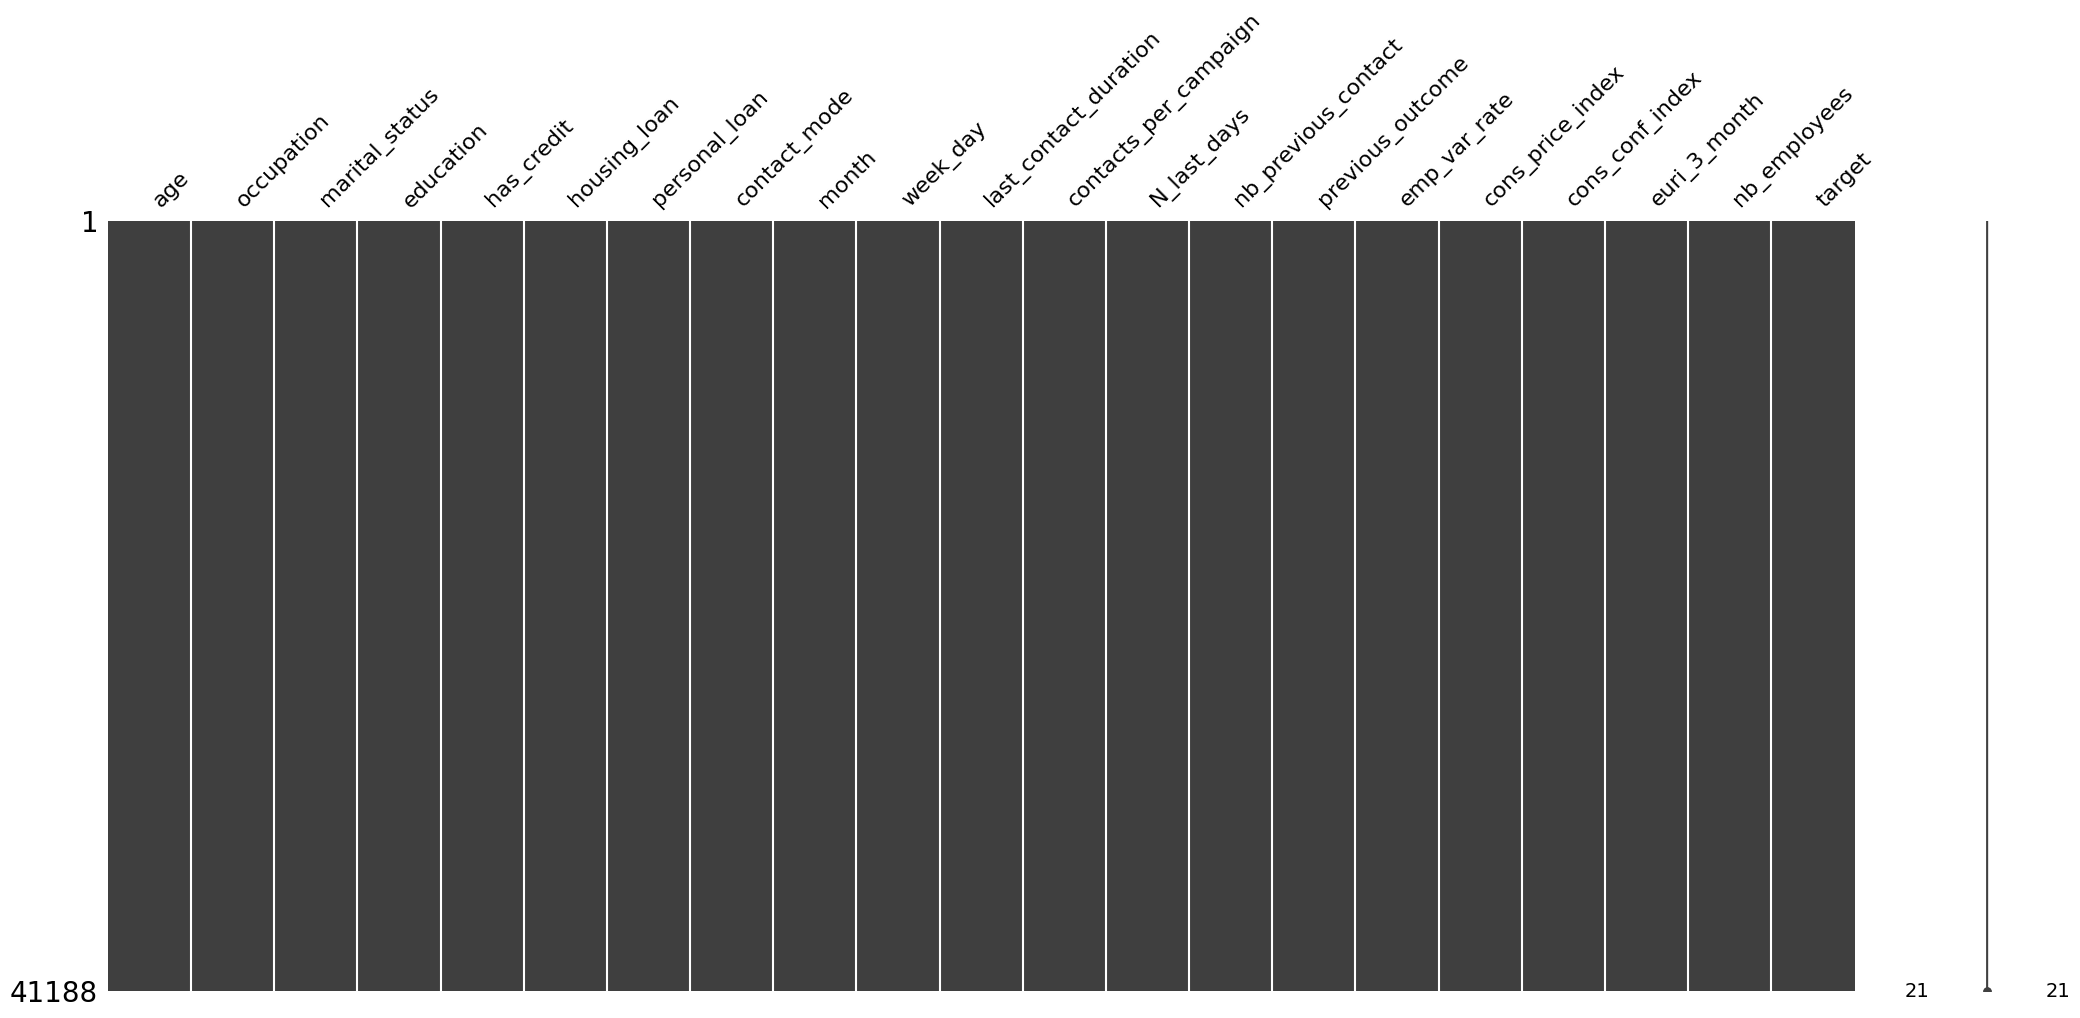

In [7]:
msno.matrix(df)

<Axes: >

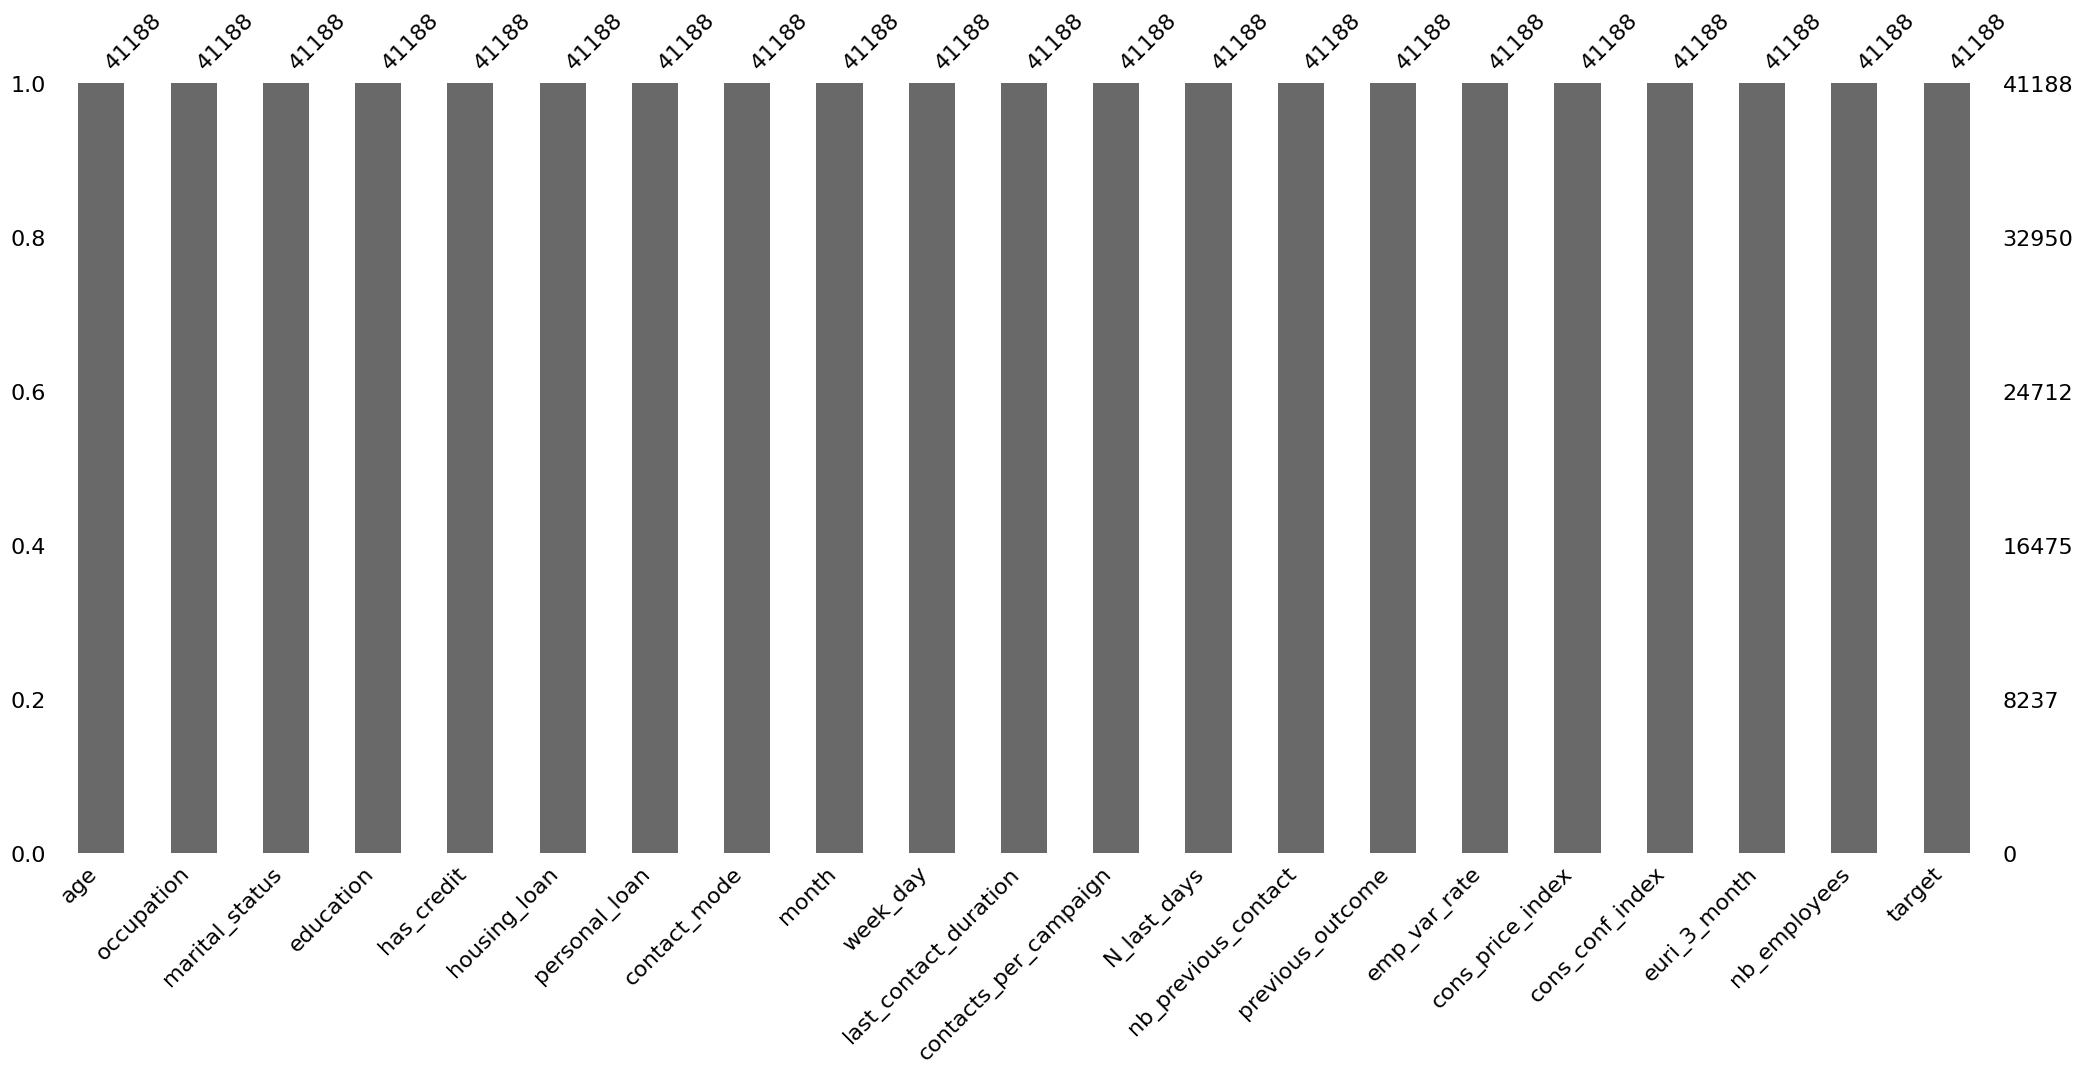

In [8]:
msno.bar(df)

In [9]:
df.stb.freq(["target"], style=True)

,target,count,percent,cumulative_count,cumulative_percent
0,no,"36,548",88.73%,"36,548",88.73%
1,yes,"4,640",11.27%,"41,188",100.00%


In [10]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df.stb.counts())

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
target,41188,2,no,36548,yes,4640
contact_mode,41188,2,cellular,26144,telephone,15044
has_credit,41188,3,no,32588,yes,3
housing_loan,41188,3,yes,21576,unknown,990
personal_loan,41188,3,no,33950,unknown,990
previous_outcome,41188,3,nonexistent,35563,success,1373
marital_status,41188,4,married,24928,unknown,80
week_day,41188,5,thu,8623,fri,7827
education,41188,8,university.degree,12168,illiterate,18
nb_previous_contact,41188,8,0,35563,7,1


In [11]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.counts())

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.counts())

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
target,36548,1,no,36548,no,36548
contact_mode,36548,2,cellular,22291,telephone,14257
has_credit,36548,3,no,28391,yes,3
housing_loan,36548,3,yes,19069,unknown,883
personal_loan,36548,3,no,30100,unknown,883
previous_outcome,36548,3,nonexistent,32422,success,479
marital_status,36548,4,married,22396,unknown,68
week_day,36548,5,mon,7667,fri,6981
education,36548,8,university.degree,10498,illiterate,14
nb_previous_contact,36548,8,0,32422,7,1


,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
target,4640,1,yes,4640,yes,4640
has_credit,4640,2,no,4197,unknown,443
contact_mode,4640,2,cellular,3853,telephone,787
housing_loan,4640,3,yes,2507,unknown,107
personal_loan,4640,3,no,3850,unknown,107
previous_outcome,4640,3,nonexistent,3141,failure,605
marital_status,4640,4,married,2532,unknown,12
week_day,4640,5,thu,1045,fri,846
nb_previous_contact,4640,7,0,3141,6,3
education,4640,8,university.degree,1670,illiterate,4


In [12]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["contact_mode"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["contact_mode"], style=True))

,contact_mode,count,percent,cumulative_count,cumulative_percent
0,cellular,"22,291",60.99%,"22,291",60.99%
1,telephone,"14,257",39.01%,"36,548",100.00%


,contact_mode,count,percent,cumulative_count,cumulative_percent
0,cellular,"3,853",83.04%,"3,853",83.04%
1,telephone,787,16.96%,"4,640",100.00%


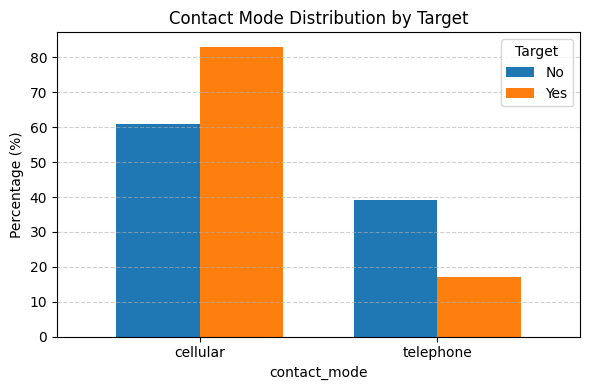

In [13]:
plot_table_stats(df, feature="contact_mode", title="Contact Mode")

In [14]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["has_credit"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["has_credit"], style=True))

,has_credit,count,percent,cumulative_count,cumulative_percent
0,no,"28,391",77.68%,"28,391",77.68%
1,unknown,"8,154",22.31%,"36,545",99.99%
2,yes,3,0.01%,"36,548",100.00%


,has_credit,count,percent,cumulative_count,cumulative_percent
0,no,"4,197",90.45%,"4,197",90.45%
1,unknown,443,9.55%,"4,640",100.00%


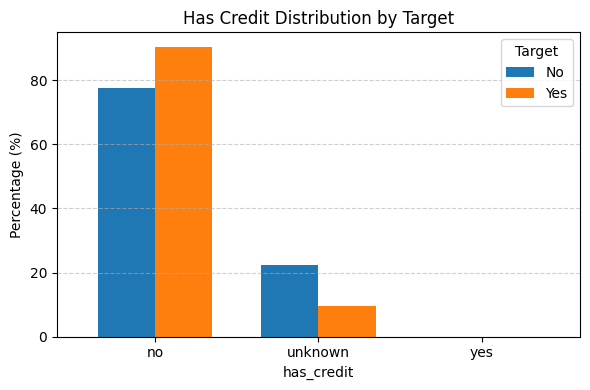

In [15]:
plot_table_stats(df, feature="has_credit", title="Has Credit")

In [16]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["housing_loan"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["housing_loan"], style=True))

,housing_loan,count,percent,cumulative_count,cumulative_percent
0,yes,"19,069",52.18%,"19,069",52.18%
1,no,"16,596",45.41%,"35,665",97.58%
2,unknown,883,2.42%,"36,548",100.00%


,housing_loan,count,percent,cumulative_count,cumulative_percent
0,yes,"2,507",54.03%,"2,507",54.03%
1,no,"2,026",43.66%,"4,533",97.69%
2,unknown,107,2.31%,"4,640",100.00%


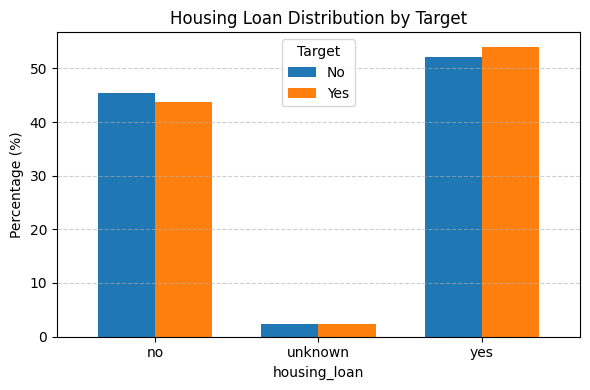

In [17]:
plot_table_stats(df, feature="housing_loan", title="Housing Loan")

In [18]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["personal_loan"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["personal_loan"], style=True))

,personal_loan,count,percent,cumulative_count,cumulative_percent
0,no,"30,100",82.36%,"30,100",82.36%
1,yes,"5,565",15.23%,"35,665",97.58%
2,unknown,883,2.42%,"36,548",100.00%


,personal_loan,count,percent,cumulative_count,cumulative_percent
0,no,"3,850",82.97%,"3,850",82.97%
1,yes,683,14.72%,"4,533",97.69%
2,unknown,107,2.31%,"4,640",100.00%


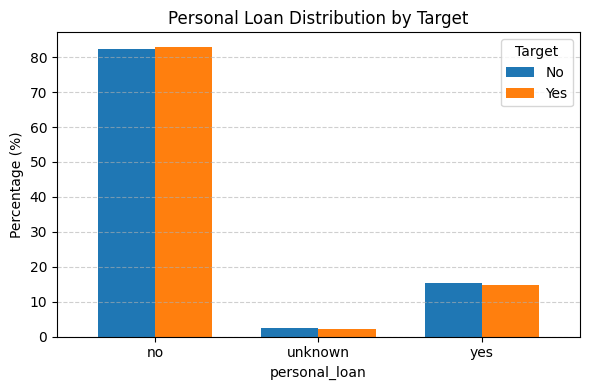

In [19]:
plot_table_stats(df, feature="personal_loan", title="Personal Loan")

In [20]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["previous_outcome"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["previous_outcome"], style=True))

,previous_outcome,count,percent,cumulative_count,cumulative_percent
0,nonexistent,"32,422",88.71%,"32,422",88.71%
1,failure,"3,647",9.98%,"36,069",98.69%
2,success,479,1.31%,"36,548",100.00%


,previous_outcome,count,percent,cumulative_count,cumulative_percent
0,nonexistent,"3,141",67.69%,"3,141",67.69%
1,success,894,19.27%,"4,035",86.96%
2,failure,605,13.04%,"4,640",100.00%


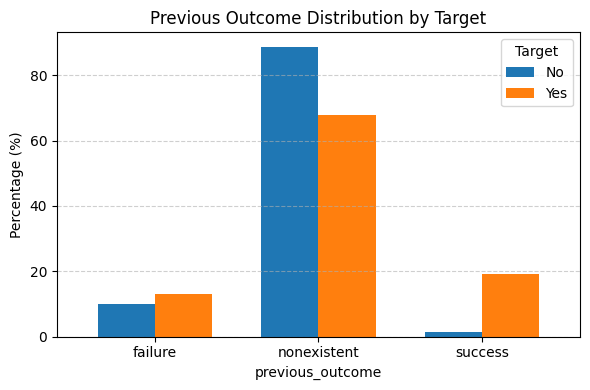

In [21]:
plot_table_stats(df, feature="previous_outcome", title="Previous Outcome")

In [22]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["marital_status"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["marital_status"], style=True))

,marital_status,count,percent,cumulative_count,cumulative_percent
0,married,"22,396",61.28%,"22,396",61.28%
1,single,"9,948",27.22%,"32,344",88.50%
2,divorced,"4,136",11.32%,"36,480",99.81%
3,unknown,68,0.19%,"36,548",100.00%


,marital_status,count,percent,cumulative_count,cumulative_percent
0,married,"2,532",54.57%,"2,532",54.57%
1,single,"1,620",34.91%,"4,152",89.48%
2,divorced,476,10.26%,"4,628",99.74%
3,unknown,12,0.26%,"4,640",100.00%


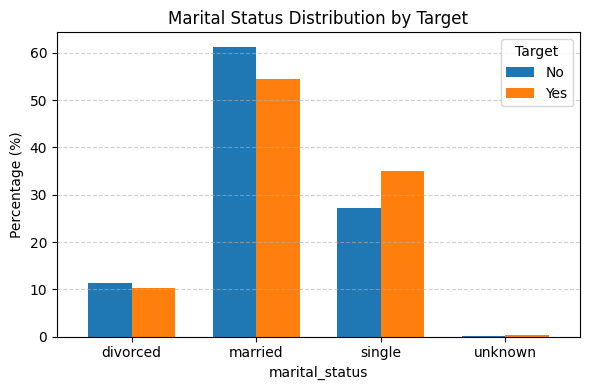

In [23]:
plot_table_stats(df, feature="marital_status", title="Marital Status")

In [24]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["week_day"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["week_day"], style=True))

,week_day,count,percent,cumulative_count,cumulative_percent
0,mon,"7,667",20.98%,"7,667",20.98%
1,thu,"7,578",20.73%,"15,245",41.71%
2,wed,"7,185",19.66%,"22,430",61.37%
3,tue,"7,137",19.53%,"29,567",80.90%
4,fri,"6,981",19.10%,"36,548",100.00%


,week_day,count,percent,cumulative_count,cumulative_percent
0,thu,"1,045",22.52%,"1,045",22.52%
1,tue,953,20.54%,"1,998",43.06%
2,wed,949,20.45%,"2,947",63.51%
3,mon,847,18.25%,"3,794",81.77%
4,fri,846,18.23%,"4,640",100.00%


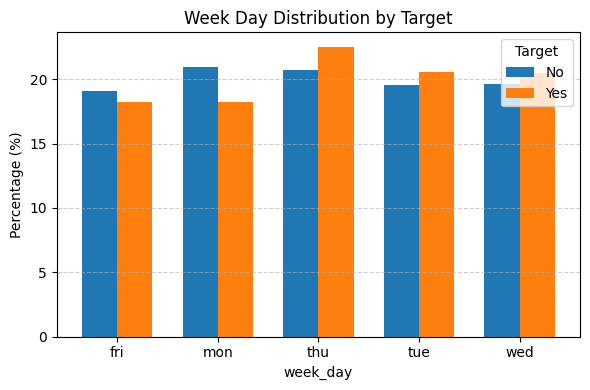

In [25]:
plot_table_stats(df, feature="week_day", title="Week Day")

In [26]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["education"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["education"], style=True))

,education,count,percent,cumulative_count,cumulative_percent
0,university.degree,"10,498",28.72%,"10,498",28.72%
1,high.school,"8,484",23.21%,"18,982",51.94%
2,basic.9y,"5,572",15.25%,"24,554",67.18%
3,professional.course,"4,648",12.72%,"29,202",79.90%
4,basic.4y,"3,748",10.26%,"32,950",90.16%
5,basic.6y,"2,104",5.76%,"35,054",95.91%
6,unknown,"1,480",4.05%,"36,534",99.96%
7,illiterate,14,0.04%,"36,548",100.00%


,education,count,percent,cumulative_count,cumulative_percent
0,university.degree,"1,670",35.99%,"1,670",35.99%
1,high.school,"1,031",22.22%,"2,701",58.21%
2,professional.course,595,12.82%,"3,296",71.03%
3,basic.9y,473,10.19%,"3,769",81.23%
4,basic.4y,428,9.22%,"4,197",90.45%
5,unknown,251,5.41%,"4,448",95.86%
6,basic.6y,188,4.05%,"4,636",99.91%
7,illiterate,4,0.09%,"4,640",100.00%


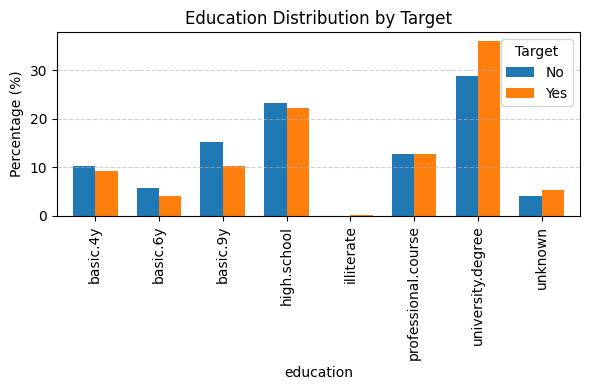

In [27]:
plot_table_stats(df, feature="education", title="Education", rotation=90)

In [28]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["nb_previous_contact"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["nb_previous_contact"], style=True))

,nb_previous_contact,count,percent,cumulative_count,cumulative_percent
0,0,"32,422",88.71%,"32,422",88.71%
1,1,"3,594",9.83%,"36,016",98.54%
2,2,404,1.11%,"36,420",99.65%
3,3,88,0.24%,"36,508",99.89%
4,4,32,0.09%,"36,540",99.98%
5,5,5,0.01%,"36,545",99.99%
6,6,2,0.01%,"36,547",100.00%
7,7,1,0.00%,"36,548",100.00%


,nb_previous_contact,count,percent,cumulative_count,cumulative_percent
0,0,"3,141",67.69%,"3,141",67.69%
1,1,967,20.84%,"4,108",88.53%
2,2,350,7.54%,"4,458",96.08%
3,3,128,2.76%,"4,586",98.84%
4,4,38,0.82%,"4,624",99.66%
5,5,13,0.28%,"4,637",99.94%
6,6,3,0.06%,"4,640",100.00%


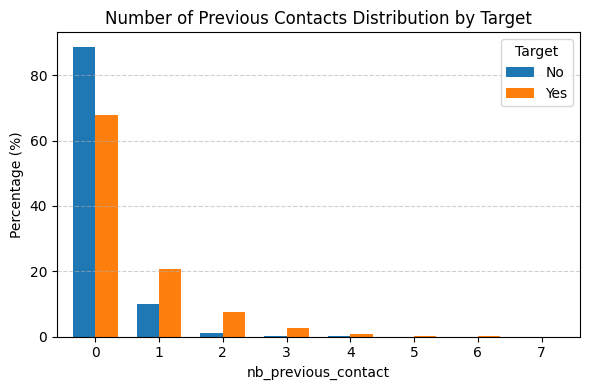

In [29]:
plot_table_stats(df, feature="nb_previous_contact", title="Number of Previous Contacts")

In [30]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["emp_var_rate"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["emp_var_rate"], style=True))

,emp_var_rate,count,percent,cumulative_count,cumulative_percent
0,1.400000,"15,368",42.05%,"15,368",42.05%
1,-1.800000,"7,723",21.13%,"23,091",63.18%
2,1.100000,"7,523",20.58%,"30,614",83.76%
3,-0.100000,"3,451",9.44%,"34,065",93.21%
4,-2.900000,"1,069",2.92%,"35,134",96.13%
5,-3.400000,617,1.69%,"35,751",97.82%
6,-1.700000,370,1.01%,"36,121",98.83%
7,-1.100000,334,0.91%,"36,455",99.75%
8,-3.000000,84,0.23%,"36,539",99.98%
9,-0.200000,9,0.02%,"36,548",100.00%


,emp_var_rate,count,percent,cumulative_count,cumulative_percent
0,-1.800000,"1,461",31.49%,"1,461",31.49%
1,1.400000,866,18.66%,"2,327",50.15%
2,-2.900000,594,12.80%,"2,921",62.95%
3,-3.400000,454,9.78%,"3,375",72.74%
4,-1.700000,403,8.69%,"3,778",81.42%
5,-1.100000,301,6.49%,"4,079",87.91%
6,1.100000,240,5.17%,"4,319",93.08%
7,-0.100000,232,5.00%,"4,551",98.08%
8,-3.000000,88,1.90%,"4,639",99.98%
9,-0.200000,1,0.02%,"4,640",100.00%


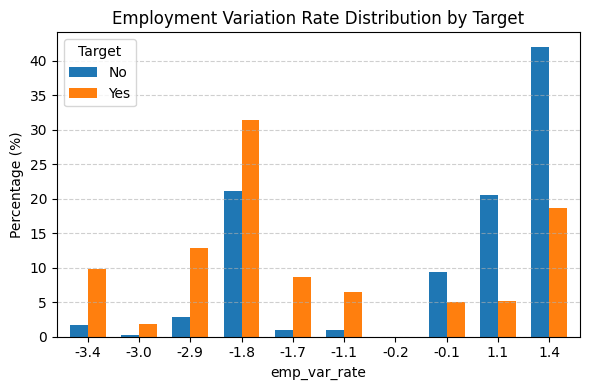

In [31]:
plot_table_stats(df, feature="emp_var_rate", title="Employment Variation Rate")

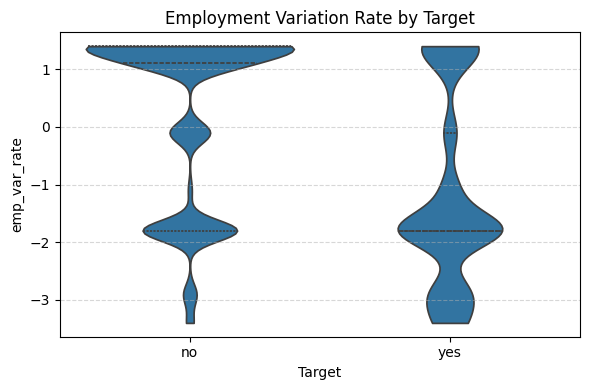

In [32]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="target", y="emp_var_rate", inner="quartile", cut=0)

plt.title("Employment Variation Rate by Target")
plt.ylabel("emp_var_rate")
plt.xlabel("Target")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [33]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["month"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["month"], style=True))

,month,count,percent,cumulative_count,cumulative_percent
0,may,"12,883",35.25%,"12,883",35.25%
1,jul,"6,525",17.85%,"19,408",53.10%
2,aug,"5,523",15.11%,"24,931",68.21%
3,jun,"4,759",13.02%,"29,690",81.24%
4,nov,"3,685",10.08%,"33,375",91.32%
5,apr,"2,093",5.73%,"35,468",97.04%
6,oct,403,1.10%,"35,871",98.15%
7,sep,314,0.86%,"36,185",99.01%
8,mar,270,0.74%,"36,455",99.75%
9,dec,93,0.25%,"36,548",100.00%


,month,count,percent,cumulative_count,cumulative_percent
0,may,886,19.09%,886,19.09%
1,aug,655,14.12%,"1,541",33.21%
2,jul,649,13.99%,"2,190",47.20%
3,jun,559,12.05%,"2,749",59.25%
4,apr,539,11.62%,"3,288",70.86%
5,nov,416,8.97%,"3,704",79.83%
6,oct,315,6.79%,"4,019",86.62%
7,mar,276,5.95%,"4,295",92.56%
8,sep,256,5.52%,"4,551",98.08%
9,dec,89,1.92%,"4,640",100.00%


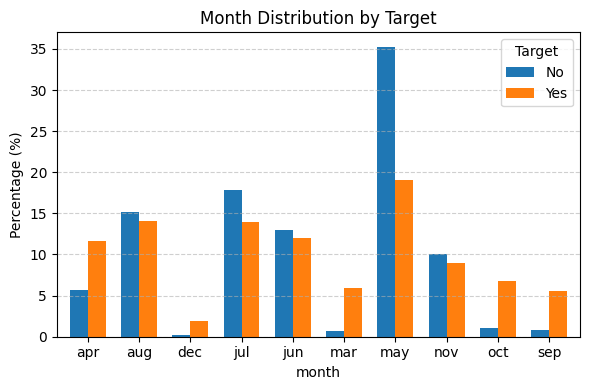

In [34]:
plot_table_stats(df, feature="month", title="Month")

In [35]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["nb_employees"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["nb_employees"], style=True))

,nb_employees,count,percent,cumulative_count,cumulative_percent
0,5228.100000,"15,368",42.05%,"15,368",42.05%
1,5191.000000,"7,523",20.58%,"22,891",62.63%
2,5099.100000,"7,442",20.36%,"30,333",82.99%
3,5195.800000,"3,451",9.44%,"33,784",92.44%
4,5076.200000,"1,069",2.92%,"34,853",95.36%
5,5017.500000,617,1.69%,"35,470",97.05%
6,4991.600000,370,1.01%,"35,840",98.06%
7,4963.600000,334,0.91%,"36,174",98.98%
8,5008.700000,281,0.77%,"36,455",99.75%
9,5023.500000,84,0.23%,"36,539",99.98%


,nb_employees,count,percent,cumulative_count,cumulative_percent
0,5099.100000,"1,092",23.53%,"1,092",23.53%
1,5228.100000,866,18.66%,"1,958",42.20%
2,5076.200000,594,12.80%,"2,552",55.00%
3,5017.500000,454,9.78%,"3,006",64.78%
4,4991.600000,403,8.69%,"3,409",73.47%
5,5008.700000,369,7.95%,"3,778",81.42%
6,4963.600000,301,6.49%,"4,079",87.91%
7,5191.000000,240,5.17%,"4,319",93.08%
8,5195.800000,232,5.00%,"4,551",98.08%
9,5023.500000,88,1.90%,"4,639",99.98%


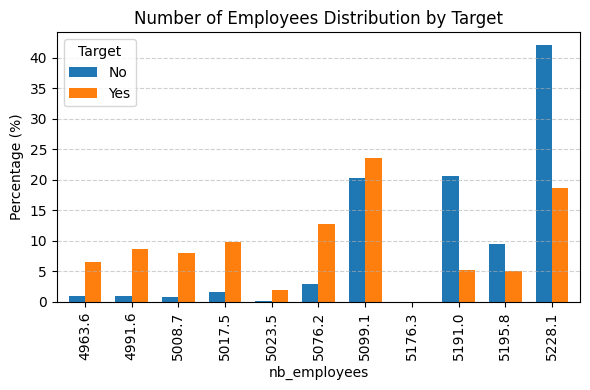

In [36]:
plot_table_stats(df, feature="nb_employees", title="Number of Employees", rotation=90)

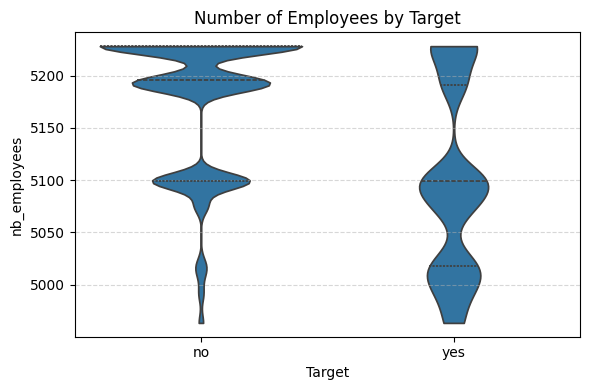

In [37]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="target", y="nb_employees", inner="quartile", cut=0)

plt.title("Number of Employees by Target")
plt.ylabel("nb_employees")
plt.xlabel("Target")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [38]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["occupation"], style=True))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["occupation"], style=True))

,occupation,count,percent,cumulative_count,cumulative_percent
0,admin.,"9,070",24.82%,"9,070",24.82%
1,blue-collar,"8,616",23.57%,"17,686",48.39%
2,technician,"6,013",16.45%,"23,699",64.84%
3,services,"3,646",9.98%,"27,345",74.82%
4,management,"2,596",7.10%,"29,941",81.92%
5,entrepreneur,"1,332",3.64%,"31,273",85.57%
6,retired,"1,286",3.52%,"32,559",89.09%
7,self-employed,"1,272",3.48%,"33,831",92.57%
8,housemaid,954,2.61%,"34,785",95.18%
9,unemployed,870,2.38%,"35,655",97.56%


,occupation,count,percent,cumulative_count,cumulative_percent
0,admin.,"1,352",29.14%,"1,352",29.14%
1,technician,730,15.73%,"2,082",44.87%
2,blue-collar,638,13.75%,"2,720",58.62%
3,retired,434,9.35%,"3,154",67.97%
4,management,328,7.07%,"3,482",75.04%
5,services,323,6.96%,"3,805",82.00%
6,student,275,5.93%,"4,080",87.93%
7,self-employed,149,3.21%,"4,229",91.14%
8,unemployed,144,3.10%,"4,373",94.25%
9,entrepreneur,124,2.67%,"4,497",96.92%


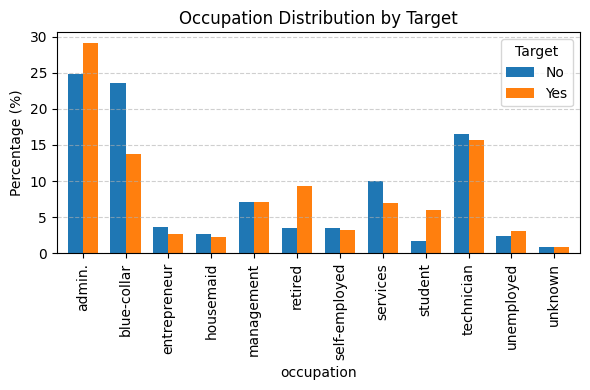

In [39]:
plot_table_stats(df, feature="occupation", title="Occupation", rotation=90)

In [40]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["N_last_days"], style=False)[:10])

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["N_last_days"], style=False)[:10])

,N_last_days,count,percent,cumulative_count,cumulative_percent
0,999,36000,98.500602,36000,98.500602
1,3,141,0.385794,36141,98.886396
2,6,123,0.336544,36264,99.222940
3,4,55,0.150487,36319,99.373427
4,12,32,0.087556,36351,99.460983
5,9,29,0.079348,36380,99.540331
6,2,24,0.065667,36404,99.605998
7,10,22,0.060195,36426,99.666192
8,7,20,0.054723,36446,99.720915
9,1,18,0.049250,36464,99.770165


,N_last_days,count,percent,cumulative_count,cumulative_percent
0,999,3673,79.159483,3673,79.159483
1,3,298,6.422414,3971,85.581897
2,6,289,6.228448,4260,91.810345
3,4,63,1.357759,4323,93.168103
4,7,40,0.862069,4363,94.030172
5,2,37,0.797414,4400,94.827586
6,9,35,0.754310,4435,95.581897
7,10,30,0.646552,4465,96.228448
8,5,29,0.625000,4494,96.853448
9,13,28,0.603448,4522,97.456897


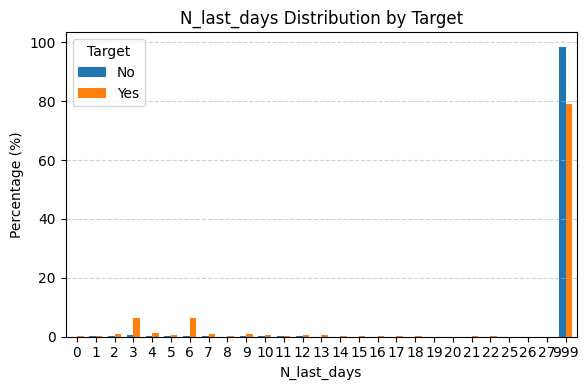

In [41]:
plot_table_stats(df, feature="N_last_days", title="N_last_days")

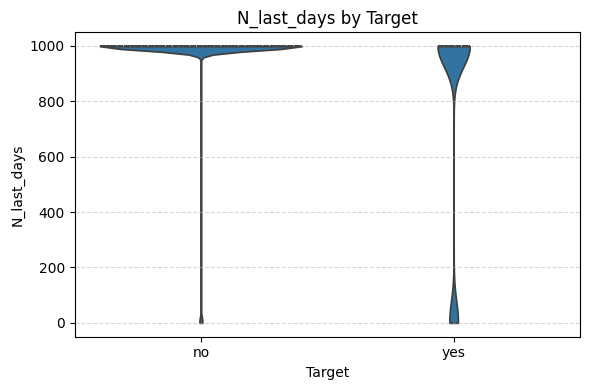

In [42]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="target", y="N_last_days", inner="quartile", cut=0)

plt.title("N_last_days by Target")
plt.ylabel("N_last_days")
plt.xlabel("Target")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [43]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["cons_price_index"], style=False)[:10])

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["cons_price_index"], style=False)[:10])

,cons_price_index,count,percent,cumulative_count,cumulative_percent
0,93.994,7523,20.583890,7523,20.583890
1,93.918,6278,17.177411,13801,37.761300
2,92.893,5270,14.419394,19071,52.180694
3,93.444,4904,13.417971,23975,65.598665
4,94.465,4186,11.453431,28161,77.052096
5,93.200,3426,9.373974,31587,86.426070
6,93.075,2016,5.516034,33603,91.942104
7,92.201,506,1.384481,34109,93.326584
8,92.963,451,1.233994,34560,94.560578
9,92.431,267,0.730546,34827,95.291124


,cons_price_index,count,percent,cumulative_count,cumulative_percent
0,92.893,524,11.293103,524,11.293103
1,93.075,442,9.525862,966,20.818966
2,93.918,407,8.771552,1373,29.590517
3,93.444,271,5.840517,1644,35.431034
4,92.963,264,5.689655,1908,41.120690
5,92.201,264,5.689655,2172,46.810345
6,93.994,240,5.172414,2412,51.982759
7,93.200,190,4.094828,2602,56.077586
8,94.465,188,4.051724,2790,60.129310
9,92.431,180,3.879310,2970,64.008621


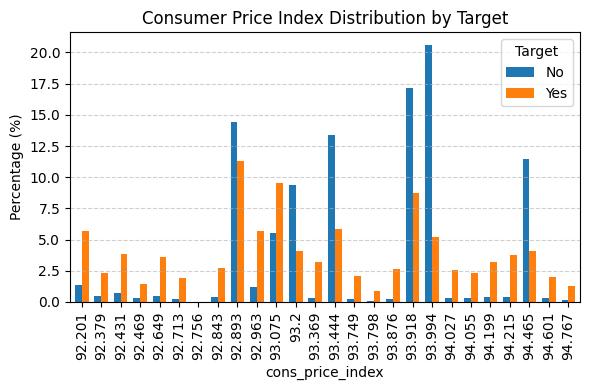

In [44]:
plot_table_stats(df, feature="cons_price_index", title="Consumer Price Index", rotation=90)

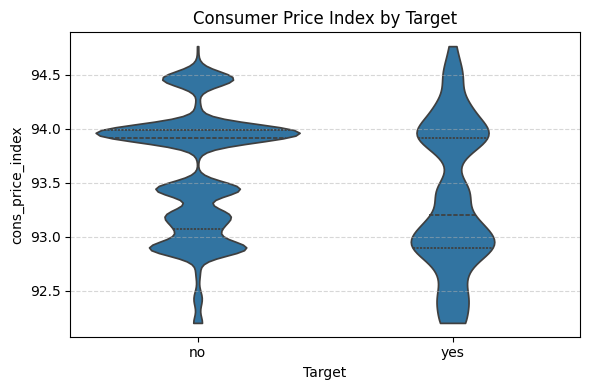

In [45]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="target", y="cons_price_index", inner="quartile", cut=0)

plt.title("Consumer Price Index by Target")
plt.ylabel("cons_price_index")
plt.xlabel("Target")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [46]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["cons_conf_index"], style=False)[:10])

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["cons_conf_index"], style=False)[:10])

,cons_conf_index,count,percent,cumulative_count,cumulative_percent
0,-36.4,7523,20.583890,7523,20.583890
1,-42.7,6278,17.177411,13801,37.761300
2,-46.2,5270,14.419394,19071,52.180694
3,-36.1,4904,13.417971,23975,65.598665
4,-41.8,4186,11.453431,28161,77.052096
5,-42.0,3426,9.373974,31587,86.426070
6,-47.1,2016,5.516034,33603,91.942104
7,-31.4,506,1.384481,34109,93.326584
8,-40.8,451,1.233994,34560,94.560578
9,-26.9,267,0.730546,34827,95.291124


,cons_conf_index,count,percent,cumulative_count,cumulative_percent
0,-46.2,524,11.293103,524,11.293103
1,-47.1,442,9.525862,966,20.818966
2,-42.7,407,8.771552,1373,29.590517
3,-36.1,271,5.840517,1644,35.431034
4,-31.4,264,5.689655,1908,41.120690
5,-40.8,264,5.689655,2172,46.810345
6,-36.4,240,5.172414,2412,51.982759
7,-42.0,190,4.094828,2602,56.077586
8,-41.8,188,4.051724,2790,60.129310
9,-26.9,180,3.879310,2970,64.008621


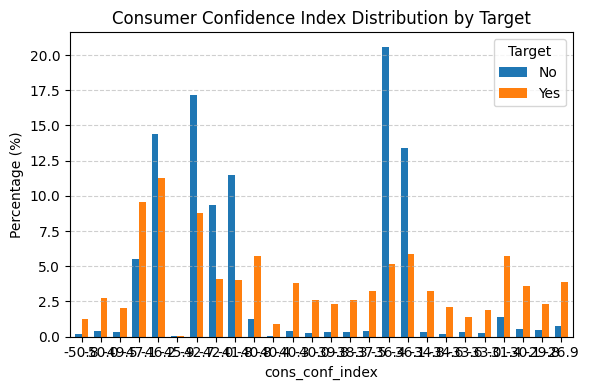

In [47]:
plot_table_stats(df, feature="cons_conf_index", title="Consumer Confidence Index")

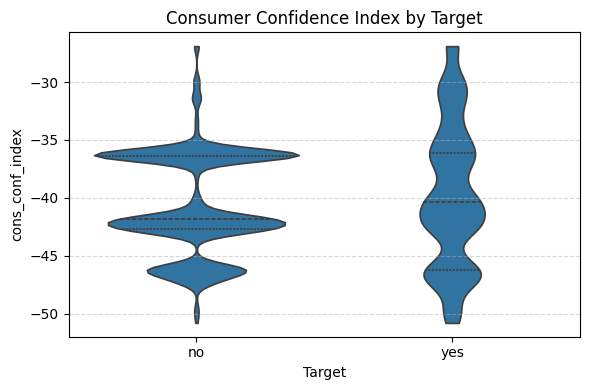

In [48]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="target", y="cons_conf_index", inner="quartile", cut=0)

plt.title("Consumer Confidence Index by Target")
plt.ylabel("cons_conf_index")
plt.xlabel("Target")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [49]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(
        df[df["target"] == "no"].stb.freq(["contacts_per_campaign"], style=False)[:10]
    )

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(
        df[df["target"] == "yes"].stb.freq(["contacts_per_campaign"], style=False)[:10]
    )

,contacts_per_campaign,count,percent,cumulative_count,cumulative_percent
0,1,15342,41.977673,15342,41.977673
1,2,9359,25.607420,24701,67.585094
2,3,4767,13.043121,29468,80.628215
3,4,2402,6.572179,31870,87.200394
4,5,1479,4.046733,33349,91.247127
5,6,904,2.473460,34253,93.720587
6,7,591,1.617052,34844,95.337638
7,8,383,1.047937,35227,96.385575
8,9,266,0.727810,35493,97.113385
9,10,213,0.582795,35706,97.696180


,contacts_per_campaign,count,percent,cumulative_count,cumulative_percent
0,1,2300,49.568966,2300,49.568966
1,2,1211,26.099138,3511,75.668103
2,3,574,12.370690,4085,88.038793
3,4,249,5.366379,4334,93.405172
4,5,120,2.586207,4454,95.991379
5,6,75,1.616379,4529,97.607759
6,7,38,0.818966,4567,98.426724
7,9,17,0.366379,4584,98.793103
8,8,17,0.366379,4601,99.159483
9,11,12,0.258621,4613,99.418103


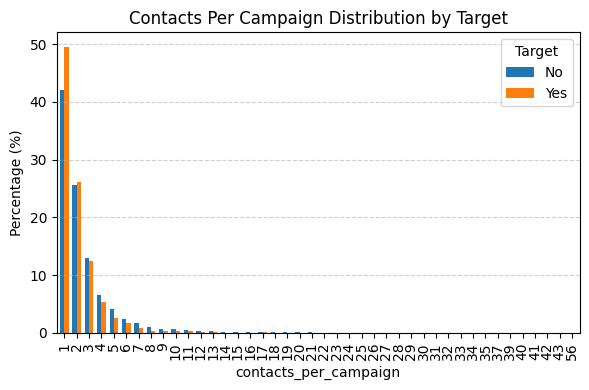

In [50]:
plot_table_stats(df, feature="contacts_per_campaign", title="Contacts Per Campaign", rotation=90)

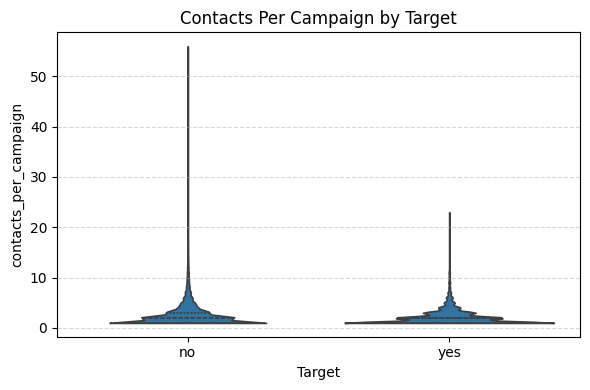

In [51]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="target", y="contacts_per_campaign", inner="quartile", cut=0)

plt.title("Contacts Per Campaign by Target")
plt.ylabel("contacts_per_campaign")
plt.xlabel("Target")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [52]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["age"], style=False)[:10])

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["age"], style=False)[:10])

,age,count,percent,cumulative_count,cumulative_percent
0,31,1727,4.725293,1727,4.725293
1,32,1662,4.547444,3389,9.272737
2,36,1626,4.448944,5015,13.721681
3,33,1623,4.440735,6638,18.162417
4,35,1592,4.355916,8230,22.518332
5,34,1561,4.271096,9791,26.789428
6,30,1512,4.137025,11303,30.926453
7,37,1338,3.660939,12641,34.587392
8,39,1318,3.606216,13959,38.193608
9,29,1267,3.466674,15226,41.660282


,age,count,percent,cumulative_count,cumulative_percent
0,31,220,4.741379,220,4.741379
1,33,210,4.525862,430,9.267241
2,30,202,4.353448,632,13.620690
3,29,186,4.008621,818,17.629310
4,34,184,3.965517,1002,21.594828
5,32,184,3.965517,1186,25.560345
6,35,167,3.599138,1353,29.159483
7,36,154,3.318966,1507,32.478448
8,28,151,3.254310,1658,35.732759
9,38,143,3.081897,1801,38.814655


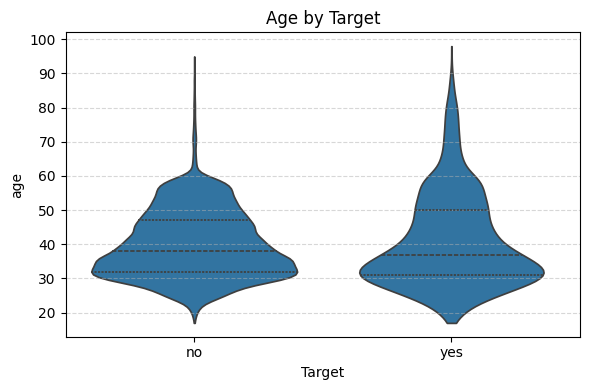

In [53]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="target", y="age", inner="quartile", cut=0)

plt.title("Age by Target")
plt.ylabel("age")
plt.xlabel("Target")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [54]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(df[df["target"] == "no"].stb.freq(["euri_3_month"], style=False)[:10])

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(df[df["target"] == "yes"].stb.freq(["euri_3_month"], style=False)[:10])

,euri_3_month,count,percent,cumulative_count,cumulative_percent
0,4.857,2796,7.650213,2796,7.650213
1,4.962,2469,6.755500,5265,14.405713
2,4.963,2361,6.459998,7626,20.865711
3,4.961,1812,4.957864,9438,25.823574
4,4.856,1178,3.223159,10616,29.046733
5,4.964,1120,3.064463,11736,32.111196
6,1.405,1034,2.829156,12770,34.940352
7,4.965,1007,2.755281,13777,37.695633
8,4.864,991,2.711503,14768,40.407136
9,4.960,956,2.615738,15724,43.022874


,euri_3_month,count,percent,cumulative_count,cumulative_percent
0,4.962,144,3.103448,144,3.103448
1,1.365,136,2.931034,280,6.034483
2,1.405,135,2.909483,415,8.943966
3,4.963,126,2.715517,541,11.659483
4,1.266,104,2.241379,645,13.900862
5,1.260,102,2.198276,747,16.099138
6,4.961,90,1.939655,837,18.038793
7,0.715,85,1.831897,922,19.870690
8,0.879,84,1.810345,1006,21.681034
9,0.714,73,1.573276,1079,23.254310


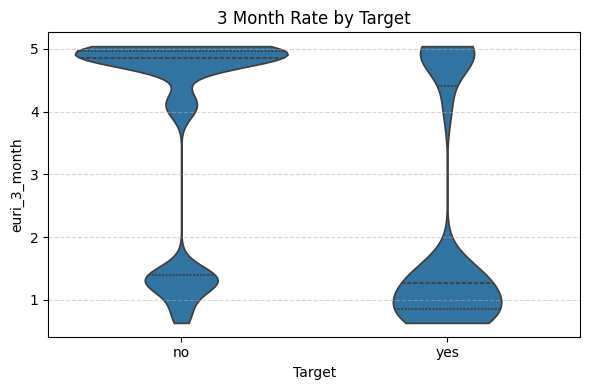

In [55]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="target", y="euri_3_month", inner="quartile", cut=0)

plt.title("3 Month Rate by Target")
plt.ylabel("euri_3_month")
plt.xlabel("Target")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [56]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>No</h4>"))
    display(
        df[df["target"] == "no"].stb.freq(["last_contact_duration"], style=False)[:10]
    )

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(HTML("<h4>Yes</h4>"))
    display(
        df[df["target"] == "yes"].stb.freq(["last_contact_duration"], style=False)[:10]
    )

,last_contact_duration,count,percent,cumulative_count,cumulative_percent
0,90,168,0.459669,168,0.459669
1,85,168,0.459669,336,0.919339
2,73,166,0.454197,502,1.373536
3,72,161,0.440517,663,1.814053
4,136,160,0.437780,823,2.251833
5,124,160,0.437780,983,2.689614
6,87,159,0.435044,1142,3.124658
7,109,157,0.429572,1299,3.554230
8,111,156,0.426836,1455,3.981066
9,104,155,0.424100,1610,4.405166


,last_contact_duration,count,percent,cumulative_count,cumulative_percent
0,301,16,0.344828,16,0.344828
1,207,15,0.323276,31,0.668103
2,187,15,0.323276,46,0.991379
3,229,14,0.301724,60,1.293103
4,209,14,0.301724,74,1.594828
5,200,14,0.301724,88,1.896552
6,192,14,0.301724,102,2.198276
7,182,14,0.301724,116,2.500000
8,252,13,0.280172,129,2.780172
9,226,13,0.280172,142,3.060345


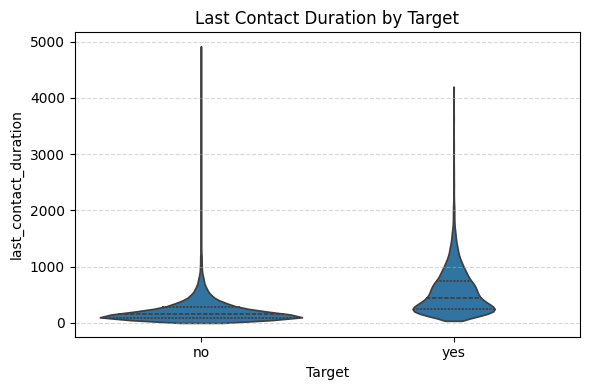

In [57]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="target", y="last_contact_duration", inner="quartile", cut=0)

plt.title("Last Contact Duration by Target")
plt.ylabel("last_contact_duration")
plt.xlabel("Target")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## 📊 Comparative Analysis: `target = no` vs `target = yes`

This analysis compares two subsets of the dataset: clients who **did not subscribe** (`target = no`) vs those who **did subscribe** (`target = yes`), aiming to extract actionable insights for predictive modeling.

---

### 📈 Previous Campaign Result: `previous_outcome`
- `success` appears more often in responders (894 vs 479).
- 🟢 **Insight**: **Prior success** is a strong positive predictor.

---

### 📅 Day of Week: `week_day`
- Best day: **Thursday (thu)**
- Worst day: **Friday (fri)**
- 🟢 **Insight**: Schedule contacts preferably on **Thursdays**.

---

### 🎓 Education: `education`
- Responders tend to be better educated (university).
- 🟢 **Insight**: **Higher education level → higher response probability**.

---

### 🔁 Previous Contacts: `nb_previous_contact`
- `0` dominates for non-responders; responders often had ≥1.
- 🟢 **Insight**: **Prior contact history is essential**.

---

### 📉 Economic Context: `emp_var_rate` / `cons_conf_index`
- Responders show **lower employment variation** and **lower confidence**.
- 🟢 **Insight**: Campaigns are more effective in **recessionary conditions**.

---

### 🕰 Days Since Last Contact: `N_last_days`
- `999` (never contacted) dominates non-responders.
- 🟢 **Insight**: **Recent engagement boosts conversion**.

---

### 🔁 Campaign Intensity: `contacts_per_campaign`
- Best results with **1 contact** per campaign.
- 🟢 **Insight**: Avoid over-contacting — **quality > quantity**.

---

### 👴 Age Distribution: `age`
- Most frequent age: **31** in both groups.
- Responders show **greater age diversity**.
- 🟢 **Insight**: Slight preference toward **younger adults**.

---

### 💶 Economic Indicators: `euri_3_month`
- Slightly **lower interest rates** correlate with responders.
- 🟢 **Insight**: Clients react to **macro-economic trends**.

---

### ⏱ Call Duration: `last_contact_duration`
- Median duration **much longer** in responders.
- 🟢 **Insight**: **Longer calls → higher response probability**.

---

### 🧠 Summary: Key Predictive Features

| Feature                  | Positive Indicator (for `target = yes`)            |
|--------------------------|----------------------------------------------------|
| `contact_mode`           | cellular                                           |
| `has_credit`             | yes                                                |
| `housing_loan` / `personal_loan` | yes                                        |
| `previous_outcome`       | success                                            |
| `education`              | university / high school                           |
| `nb_previous_contact`    | ≥ 1                                                |
| `emp_var_rate`           | negative values (economic decline)                |
| `cons_conf_index`        | low values (consumer pessimism)                   |
| `week_day`               | Thursday                                           |
| `month`                  | not May                                            |
| `contacts_per_campaign`  | 1                                                  |
| `last_contact_duration`  | high                                               |
| `N_last_days`            | recent contact (≠ 999)                             |
| `occupation`             | known                                              |
| `age`                    | 31–45 range                                        |


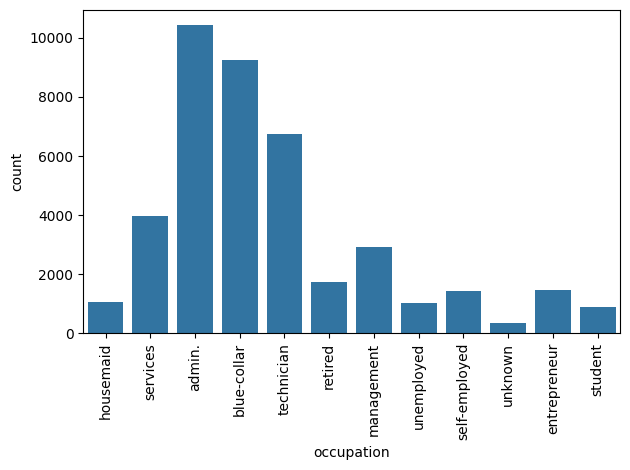

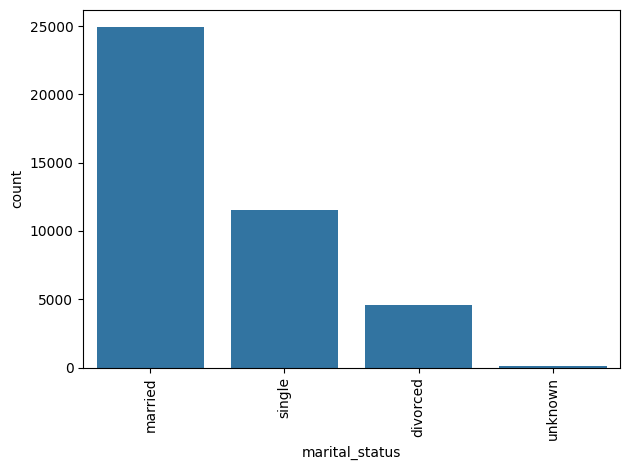

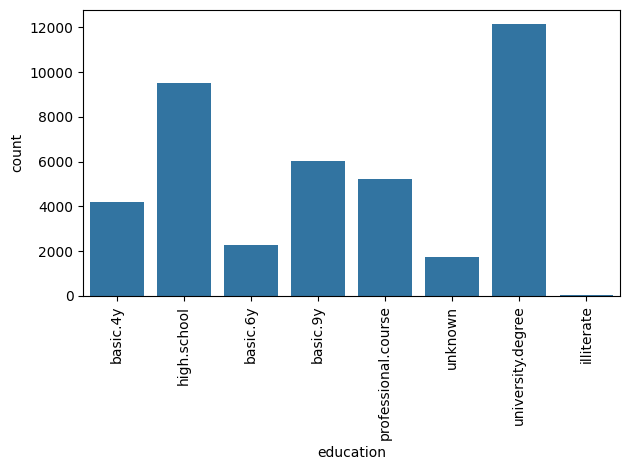

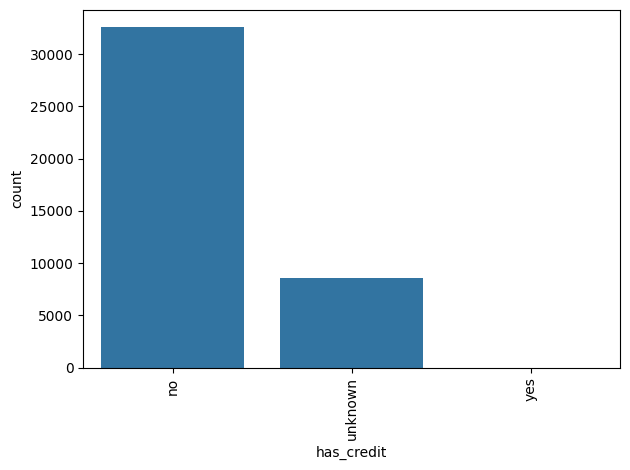

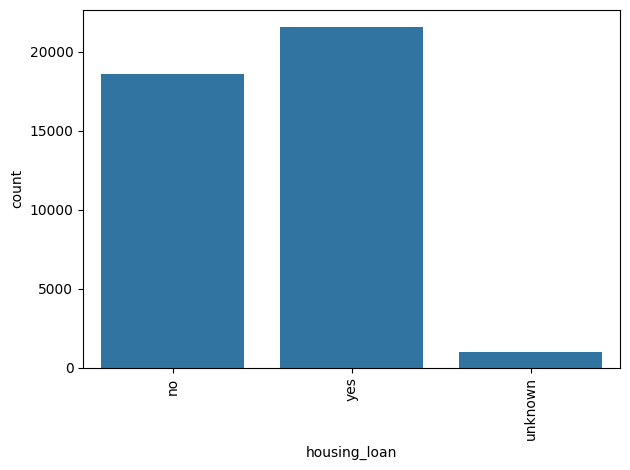

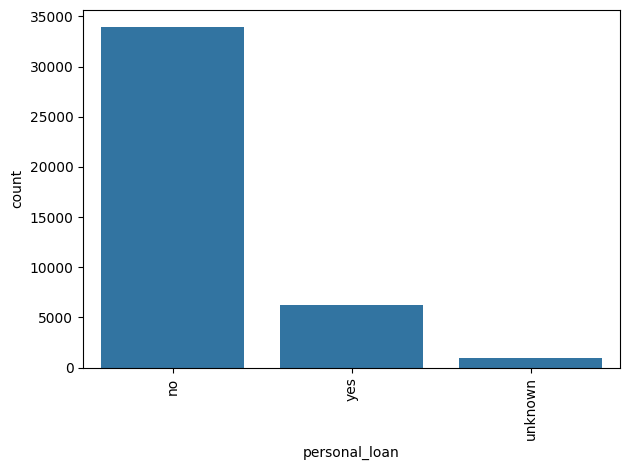

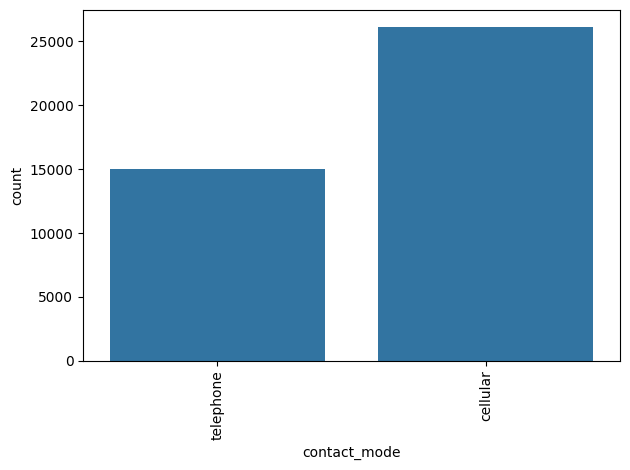

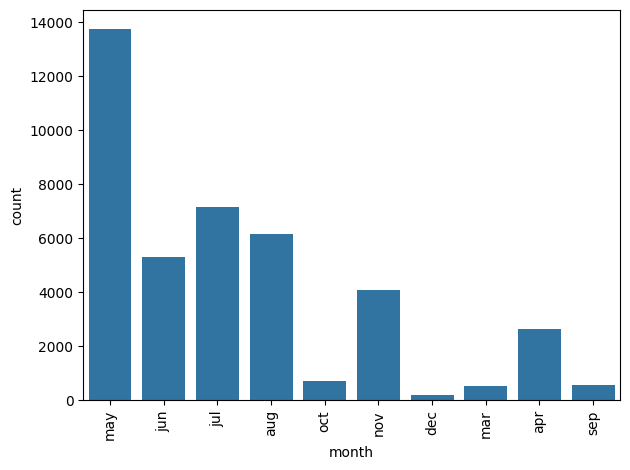

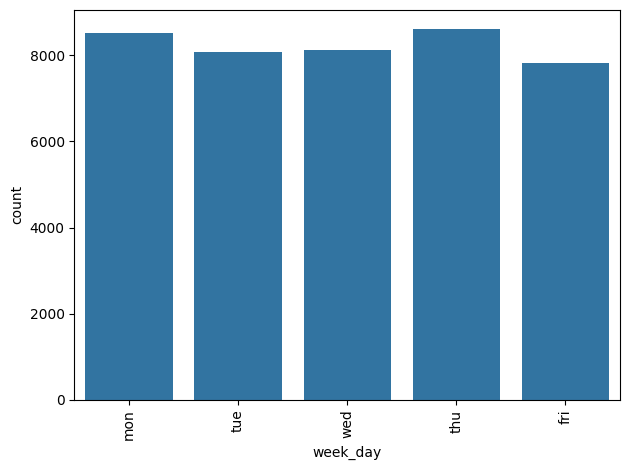

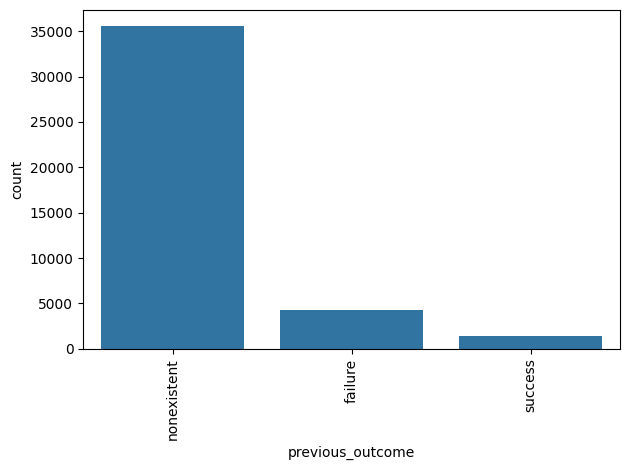

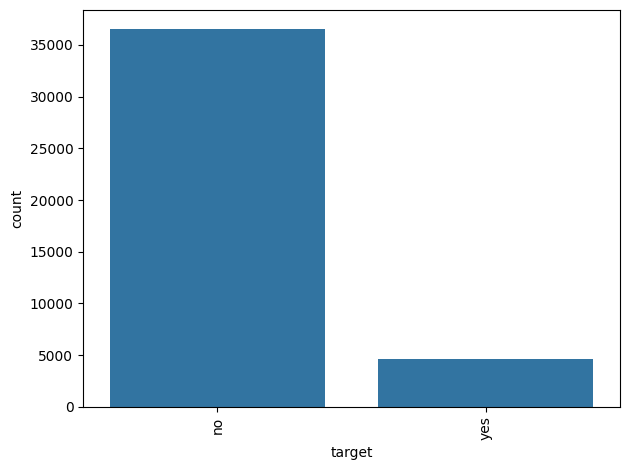

In [58]:
for col in df.select_dtypes(include=["object"]).columns:
    sns.countplot(x=col, data=df)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

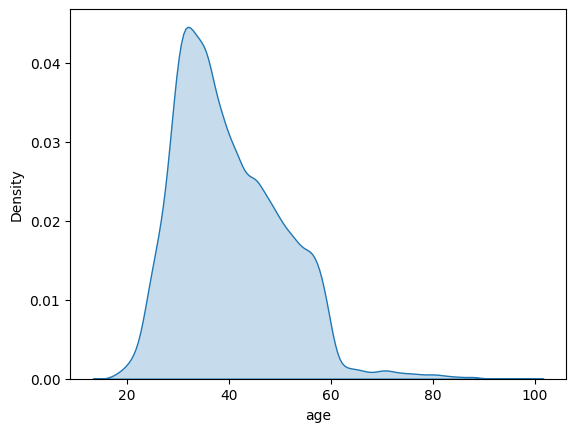

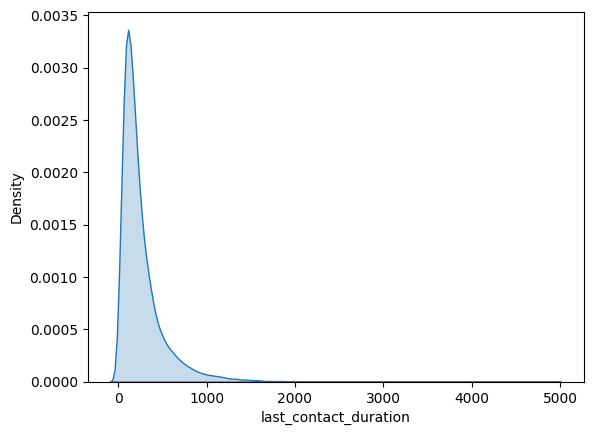

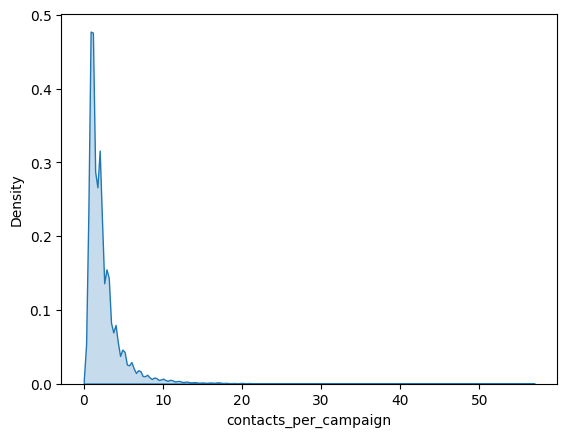

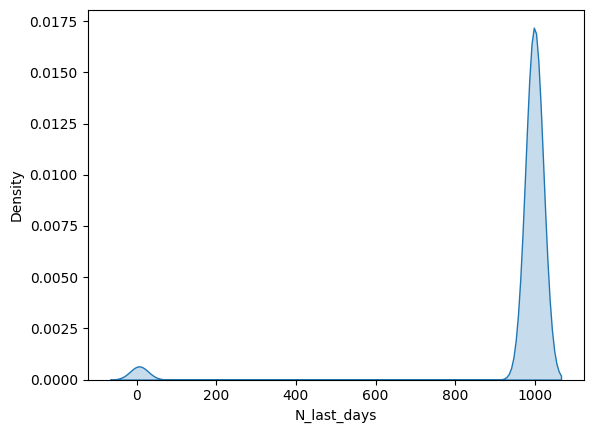

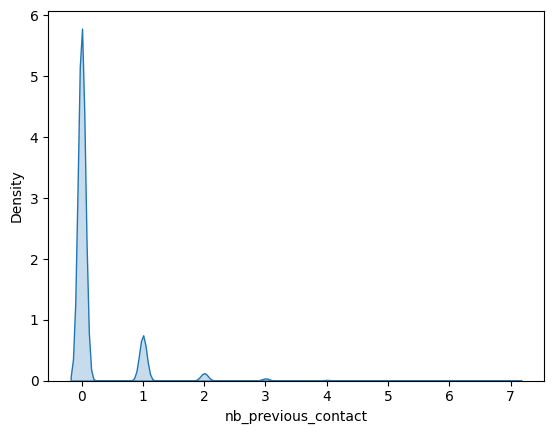

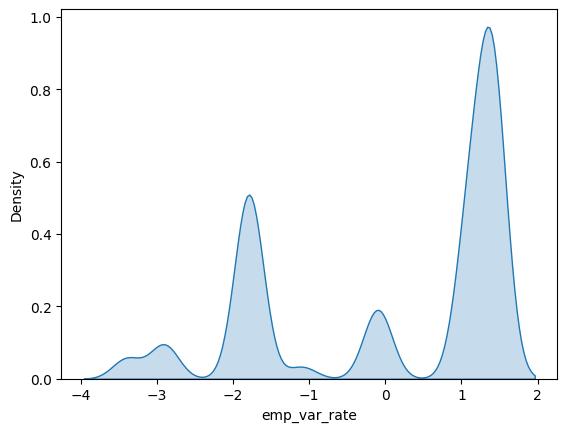

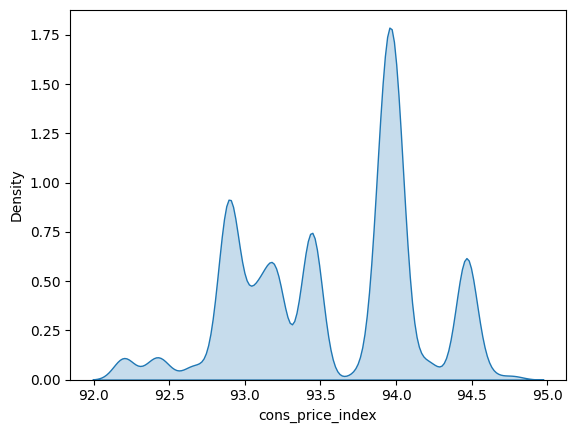

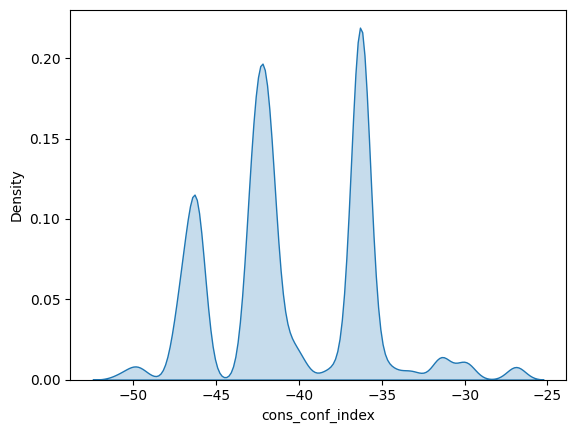

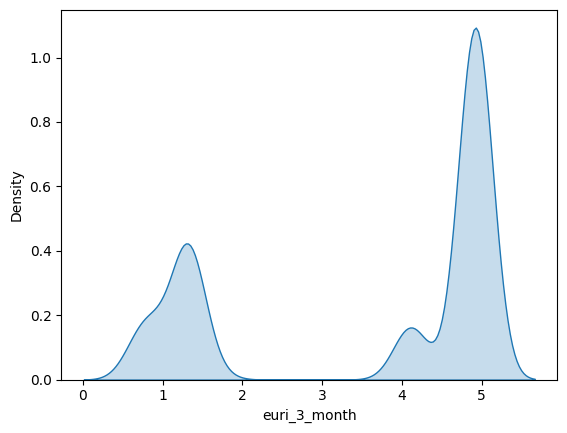

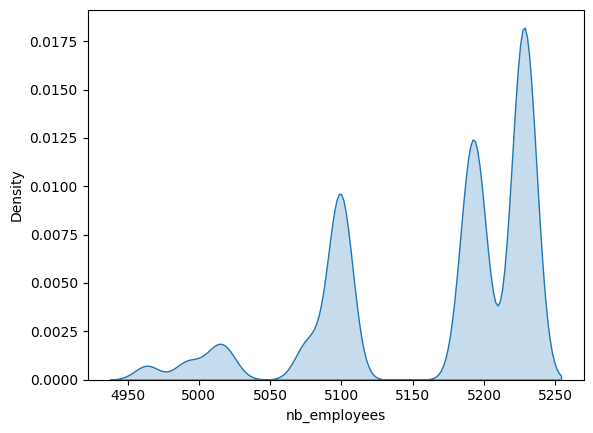

In [59]:
for col in df.select_dtypes(include=["int64", "float64"]).columns:
    sns.kdeplot(x=df[col], fill=True)
    plt.show()

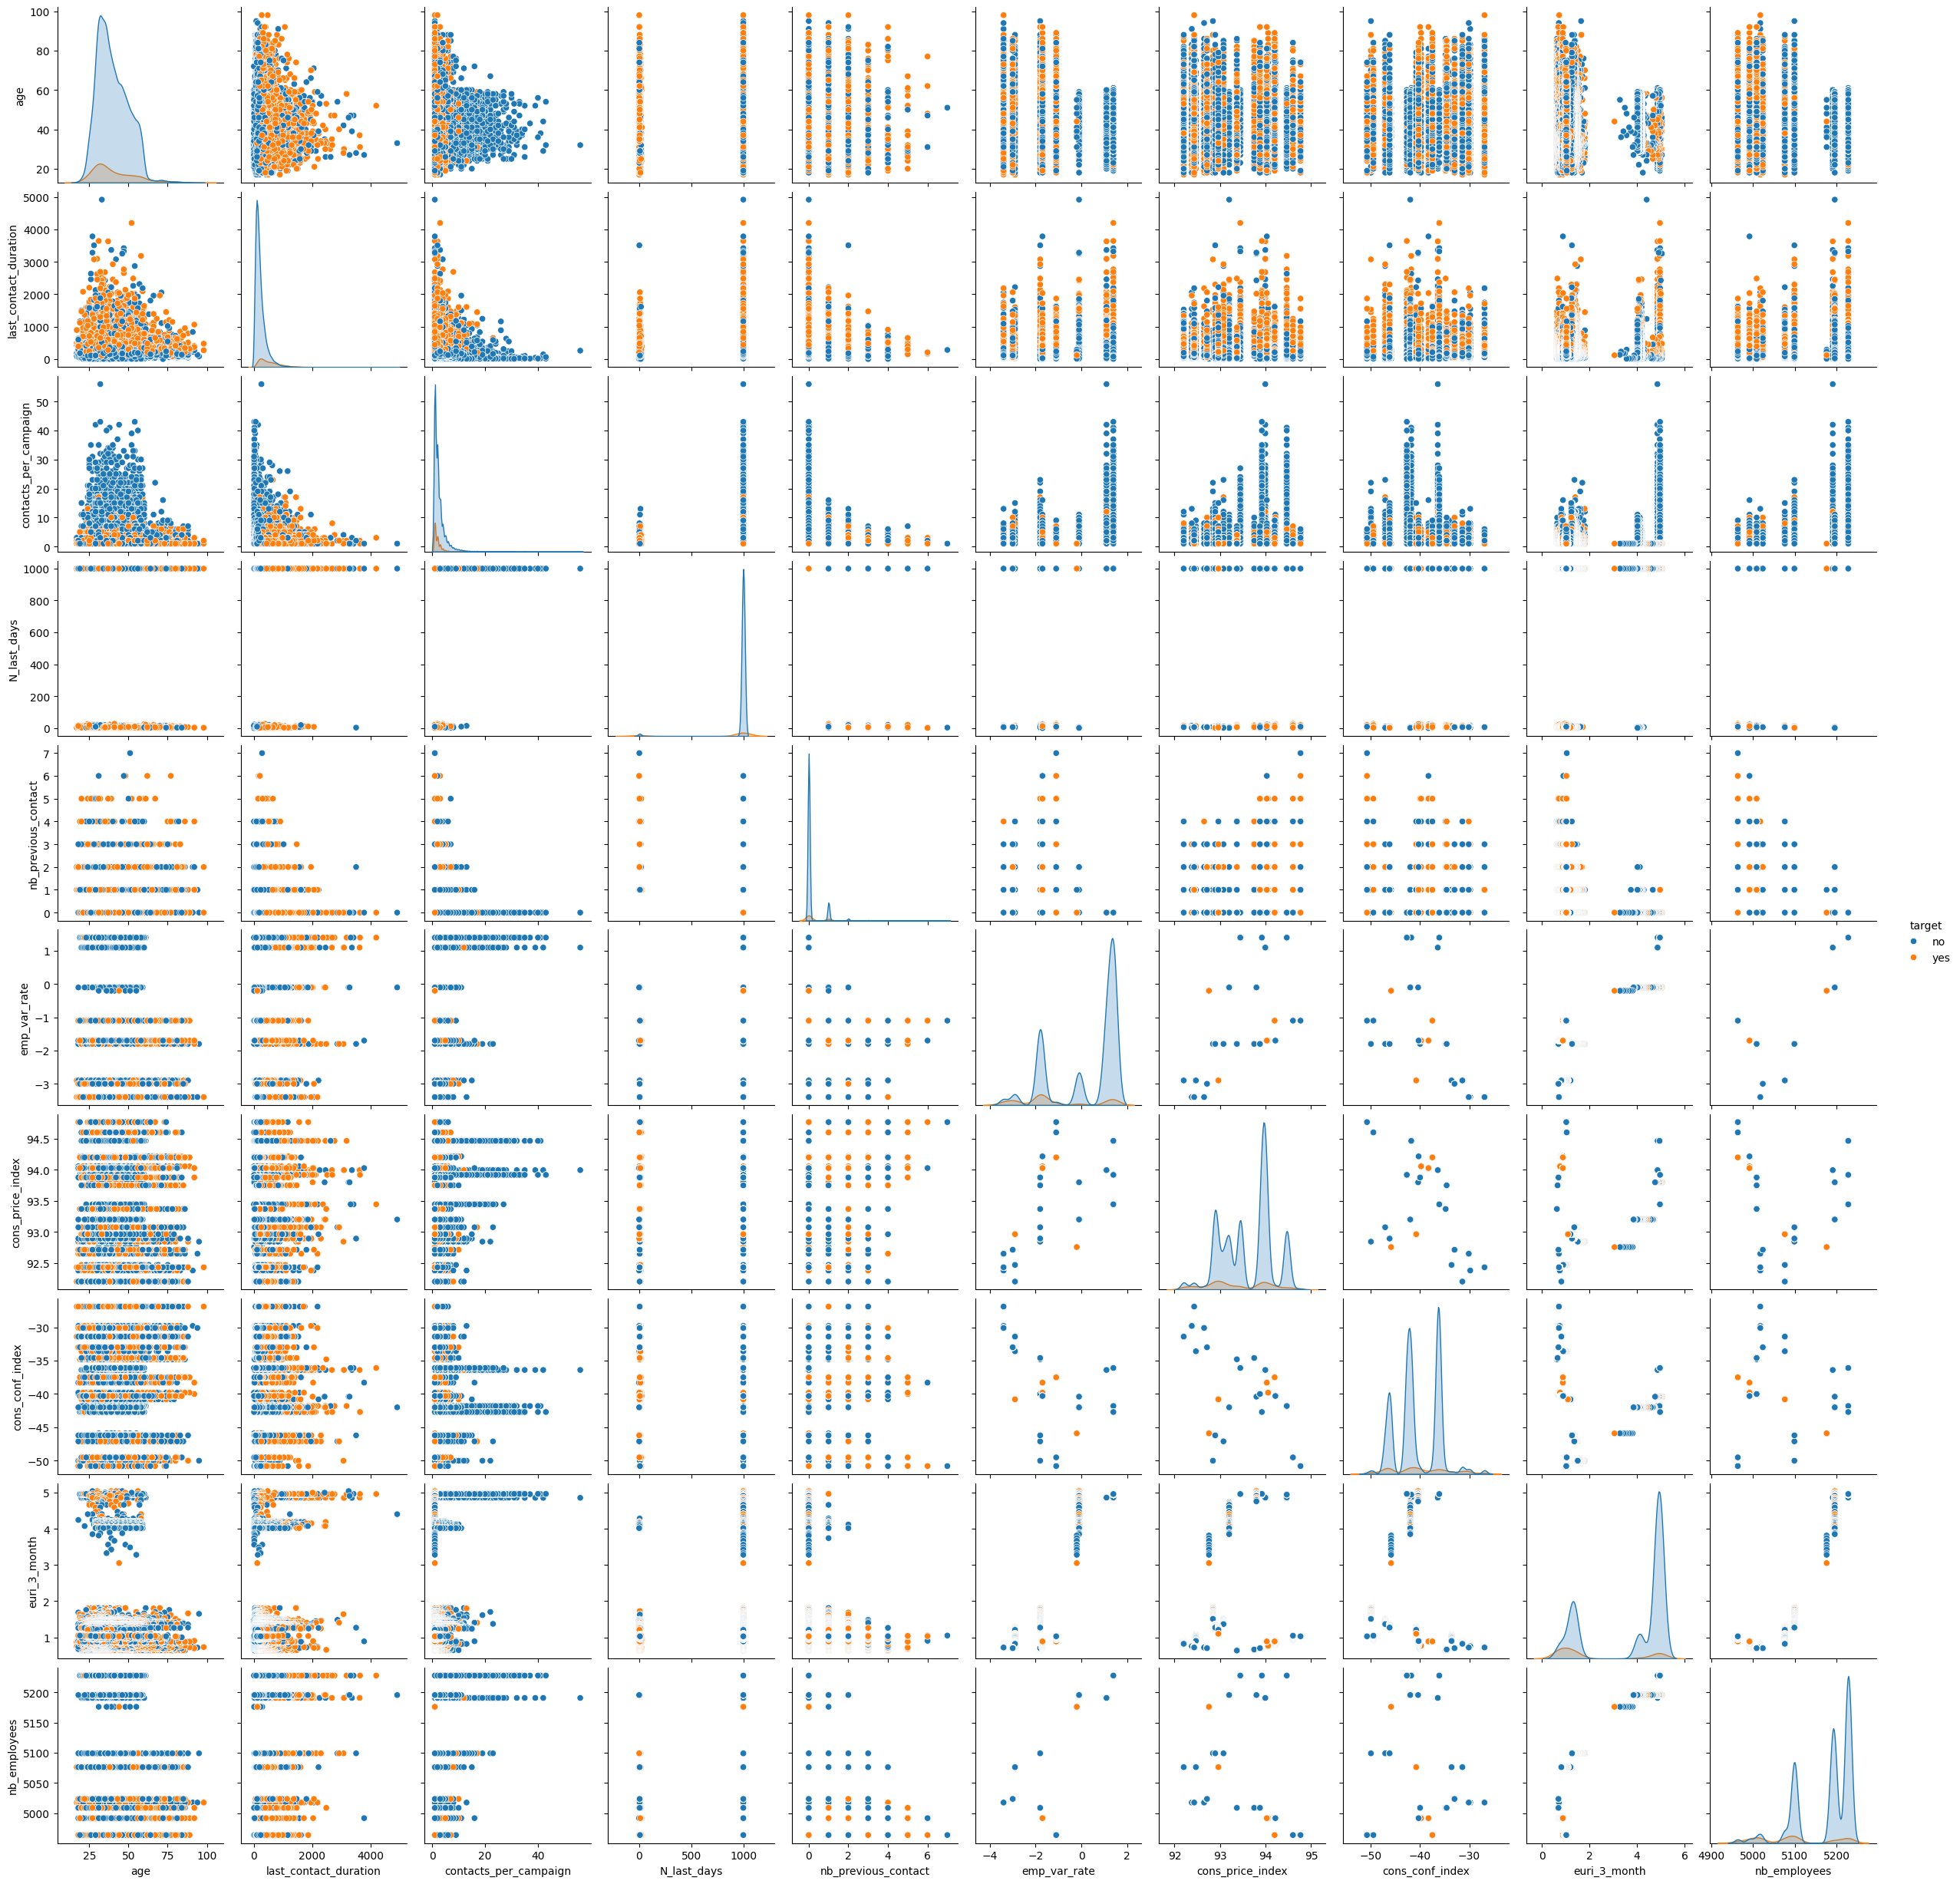

In [60]:
sns.pairplot(
    df[df.select_dtypes(include=["int64", "float64"]).columns.tolist() + ["target"]],
    hue="target",
    diag_kind="kde",
)

In [61]:
# N_last_days = 999 means that the customer has no previous contacts
df[df["N_last_days"] == 999].stb.counts()

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
N_last_days,39673,1,999,39673,999,39673
target,39673,2,no,36000,yes,3673
contact_mode,39673,2,cellular,24742,telephone,14931
previous_outcome,39673,2,nonexistent,35563,failure,4110
has_credit,39673,3,no,31137,yes,3
housing_loan,39673,3,yes,20741,unknown,956
personal_loan,39673,3,no,32699,unknown,956
marital_status,39673,4,married,24131,unknown,75
week_day,39673,5,thu,8280,fri,7581
nb_previous_contact,39673,7,0,35563,6,1


In [62]:
# Add new features
df = add_engineered_features(df)

### 📊 Engineered Feature Explanation

Below is a detailed description of the custom features created for improving the performance of gradient boosting models (e.g., CatBoost).

---

#### 🔹 `age_group`
- **Description**: Categorizes `age` into three bins: `young` (≤30), `middle` (31–55), and `senior` (>55).
- **Rationale**: Age influences financial preferences and product interest. Grouping into segments helps models learn age-related behavior patterns.

---

#### 🔹 `education_marital`
- **Description**: Cross-feature combining `education` and `marital_status` as a single categorical string (e.g., `"tertiary_single"`).
- **Rationale**: Captures socio-economic interactions—certain combinations may respond differently to marketing campaigns.

---

#### 🔹 `interest_diff`
- **Description**: Difference between `cons_price_index` (CPI) and `euri_3_month` (3-month Euribor).
- **Rationale**: Represents the spread between inflation and interest rates. A larger spread may signal economic pressure or uncertainty.

---

#### 🔹 `month_weekday`
- **Description**: Concatenation of `month` and `week_day` (e.g., `"may_tue"`).
- **Rationale**: Reflects temporal patterns in contact effectiveness—some combinations may correlate with higher conversion likelihood.

---

#### 🔹 `interest_pressure_ratio`
- **Description**: Ratio of `cons_price_index` to `euri_3_month`, with a small epsilon added to avoid division by zero.
- **Rationale**: Relative indicator of financial pressure. High values may imply inflation outpaces borrowing cost.

---

#### 🔹 `log_duration`
- **Description**: Log-transformed `last_contact_duration` using `log1p` to handle skew and zero values.
- **Rationale**: Long-tail distribution is compressed for better numeric stability and improved model learning.

---

#### 🔹 `season`
- **Description**: Maps `month` to a seasonal label (`spring`, `summer`, `autumn`, `winter`).
- **Rationale**: Aggregates monthly seasonality into broader categories to reduce cardinality and expose seasonal behavioral effects.

---

#### 🔹 `loan_burden_score`
- **Description**: Sum of two binary indicators: whether the client has a `housing_loan` and/or a `personal_loan`.
- **Rationale**: Measures cumulative debt burden. Clients with more loans may exhibit different response propensities.

---

#### 🔹 `volatility_score`
- **Description**: Sum of absolute values of `emp_var_rate`, `cons_conf_index`, and `euri_3_month`.
- **Rationale**: Synthetic macroeconomic uncertainty index. Captures the combined effect of employment, confidence, and interest fluctuations on consumer sentiment.

---

In [63]:
df = df.drop(
    columns=[
        "nb_previous_contact",
        "N_last_days",
        "loan_burden_score",
    ]
)

#### Final dataframe

In [64]:
df.head()

,age,occupation,marital_status,education,has_credit,housing_loan,personal_loan,contact_mode,month,week_day,...,nb_employees,target,age_group,education_marital,interest_diff,month_weekday,interest_pressure_ratio,log_duration,season,volatility_score
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,5191.0,no,senior,basic.4y_married,89.137,may_mon,19.348291,5.568345,spring,42.357
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,5191.0,no,senior,high.school_married,89.137,may_mon,19.348291,5.010635,spring,42.357
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,5191.0,no,middle,high.school_married,89.137,may_mon,19.348291,5.424950,spring,42.357
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,5191.0,no,middle,basic.6y_married,89.137,may_mon,19.348291,5.023881,spring,42.357
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,5191.0,no,senior,high.school_married,89.137,may_mon,19.348291,5.730100,spring,42.357


In [65]:
df.stb.counts()

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
contact_mode,41188,2,cellular,26144,telephone,15044
target,41188,2,no,36548,yes,4640
age_group,41188,3,middle,30223,senior,3582
previous_outcome,41188,3,nonexistent,35563,success,1373
has_credit,41188,3,no,32588,yes,3
housing_loan,41188,3,yes,21576,unknown,990
personal_loan,41188,3,no,33950,unknown,990
season,41188,4,summer,18670,winter,182
marital_status,41188,4,married,24928,unknown,80
week_day,41188,5,thu,8623,fri,7827


In [66]:
# sns.pairplot(
#     df[df.select_dtypes(include=["int64", "float64"]).columns.tolist() + ["target"]].sample(n=10000, random_state=42),
#     hue="target",
#     diag_kind="kde",
# )

### Modeling

In [67]:
categorial_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

In [68]:
categorial_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
categorial_features.remove("target")
categorial_features.extend(["month_weekday"])
categorial_features

['occupation',
 'marital_status',
 'education',
 'has_credit',
 'housing_loan',
 'personal_loan',
 'contact_mode',
 'month',
 'week_day',
 'previous_outcome',
 'age_group',
 'education_marital',
 'month_weekday',
 'season',
 'month_weekday']

In [69]:
target_dict = {"yes": 1, "no": 0}
df.loc[:, "target"] = df["target"].map(target_dict)
df.loc[:, "target"] = df.astype("category")

In [70]:
y = df.pop("target")
y = y.astype(int)

In [71]:
df.head()

,age,occupation,marital_status,education,has_credit,housing_loan,personal_loan,contact_mode,month,week_day,...,euri_3_month,nb_employees,age_group,education_marital,interest_diff,month_weekday,interest_pressure_ratio,log_duration,season,volatility_score
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,4.857,5191.0,senior,basic.4y_married,89.137,may_mon,19.348291,5.568345,spring,42.357
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,4.857,5191.0,senior,high.school_married,89.137,may_mon,19.348291,5.010635,spring,42.357
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,4.857,5191.0,middle,high.school_married,89.137,may_mon,19.348291,5.424950,spring,42.357
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,4.857,5191.0,middle,basic.6y_married,89.137,may_mon,19.348291,5.023881,spring,42.357
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,4.857,5191.0,senior,high.school_married,89.137,may_mon,19.348291,5.730100,spring,42.357


In [72]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    df, y, val_size=0.1, test_size=0.2, use_stratification=True, random_state=42
)

In [73]:
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

In [74]:
y_val.value_counts(normalize=True)

target
0    0.887351
1    0.112649
Name: proportion, dtype: float64

In [75]:
y_train_full.value_counts(normalize=True)

target
0    0.887344
1    0.112656
Name: proportion, dtype: float64

In [76]:
y_train_full.info()

<class 'pandas.core.series.Series'>
Index: 32950 entries, 37802 to 8127
Series name: target
Non-Null Count  Dtype
--------------  -----
32950 non-null  int64
dtypes: int64(1)
memory usage: 514.8 KB


In [77]:
classes = np.unique(y_train_full)
class_weights = compute_class_weight(
    class_weight="balanced", classes=classes, y=y_train_full
)
class_weights = class_weights.tolist()
class_weights

[0.5634790341336616, 4.438308189655173]

In [78]:
def optimize_catboost(
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 5,
    n_repeats: Optional[int] = None,
    n_trials: int = 50,
    random_state: int = 42,
    max_iterations: int = 1000,
    optimize_metric: Literal["F1", "Recall"] = "F1",
) -> Tuple[optuna.Study, Dict[str, Any], pd.DataFrame]:
    """
    Optimize CatBoost hyperparameters for imbalanced classification, including class_weights,
    using StratifiedKFold/RepeatedStratifiedKFold and Optuna.
    """

    import warnings

    warnings.filterwarnings("ignore", category=UserWarning)

    if optimize_metric not in ["F1", "Recall"]:
        raise ValueError("optimize_metric must be either 'F1' or 'Recall'.")

    # assert not y.isnull().any(), "Target y contains NaN values."

    def objective(trial: optuna.Trial) -> float:
        """Objective function to optimize."""
        params = {
            "loss_function": "Logloss",
            "eval_metric": optimize_metric,
            "custom_metric": ["Logloss"],
            "iterations": max_iterations,
            "use_best_model": False,
            "metric_period": 1,
            "depth": trial.suggest_int("depth", 3, 14),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.4, log=True),
            "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 100, log=True),
            "random_strength": trial.suggest_float(
                "random_strength", 1e-2, 10.0, log=True
            ),
            "border_count": trial.suggest_int("border_count", 32, 256),
            "auto_class_weights": "Balanced",
            "verbose": 0,
            "random_seed": random_state,
            "allow_writing_files": False,
        }

        if n_repeats:
            skf = RepeatedStratifiedKFold(
                n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
            )
        else:
            skf = StratifiedKFold(
                n_splits=n_splits, shuffle=True, random_state=random_state
            )

        scoring_func = recall_score if optimize_metric == "Recall" else f1_score

        fold_scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = CatBoostClassifier(**params, cat_features=categorial_features)
            model.fit(X_train, y_train, eval_set=(X_val, y_val))

            y_pred = model.predict(X_val)
            fold_scores.append(scoring_func(y_val, y_pred, pos_label=1))

        return np.mean(fold_scores)

    # Create and configure Optuna study
    study = optuna.create_study(direction="maximize")

    # Entry point for optimization
    study.enqueue_trial(
        {
            "depth": 14,
            "learning_rate": 0.010864262063763354,
            "l2_leaf_reg": 6,
            "random_strength": 2.1957899361410305,
            "border_count": 216,
        }
    )

    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

    best_params = study.best_trial.params

    # Merge static params back
    fixed_params = {
        "loss_function": "Logloss",
        "eval_metric": optimize_metric,
        "custom_metric": ["Logloss"],
        "iterations": max_iterations,
        "use_best_model": False,
        "metric_period": 1,
        "verbose": 0,
        "random_seed": random_state,
        "allow_writing_files": False,
    }

    best_params.update(fixed_params)

    # Final CV pass
    def cross_val_iterations(
        X: pd.DataFrame,
        y: pd.Series,
        params: Dict[str, Any],
        n_splits: int,
        n_repeats: Optional[int],
        random_state: int,
        main_metric: str,
    ) -> pd.DataFrame:
        """Manual CV to gather iteration-wise statistics."""
        if n_repeats:
            skf = RepeatedStratifiedKFold(
                n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
            )
        else:
            skf = StratifiedKFold(
                n_splits=n_splits, shuffle=True, random_state=random_state
            )

        train_metric_folds, test_metric_folds = [], []
        train_logloss_folds, test_logloss_folds = [], []

        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = CatBoostClassifier(**params, cat_features=categorial_features)
            model.fit(X_train, y_train, eval_set=(X_val, y_val))

            results = model.get_evals_result()
            train_key, test_key = "learn", "validation"
            if test_key not in results:
                # older catboost versions might store "eval"
                test_key = "eval"

            # The main metric might be "F1" or "Recall", custom metric is "Logloss"
            # Example: results["learn"]["F1"] or results["learn"]["Recall"]
            train_metric_folds.append(results[train_key][main_metric])
            test_metric_folds.append(results[test_key][main_metric])

            # If "Logloss" not found, fallback to "TotalLoss"
            if "Logloss" in results[train_key]:
                train_logloss_folds.append(results[train_key]["Logloss"])
                test_logloss_folds.append(results[test_key]["Logloss"])
            else:
                train_logloss_folds.append(results[train_key]["TotalLoss"])
                test_logloss_folds.append(results[test_key]["TotalLoss"])

        n_iters = len(train_metric_folds[0])

        data = []
        for i in range(n_iters):
            data.append(
                {
                    "iteration": i + 1,
                    f"train-{main_metric}-mean": np.mean(
                        [fold[i] for fold in train_metric_folds]
                    ),
                    f"train-{main_metric}-std": np.std(
                        [fold[i] for fold in train_metric_folds], ddof=1
                    ),
                    f"test-{main_metric}-mean": np.mean(
                        [fold[i] for fold in test_metric_folds]
                    ),
                    f"test-{main_metric}-std": np.std(
                        [fold[i] for fold in test_metric_folds], ddof=1
                    ),
                    "train-Logloss-mean": np.mean(
                        [fold[i] for fold in train_logloss_folds]
                    ),
                    "train-Logloss-std": np.std(
                        [fold[i] for fold in train_logloss_folds], ddof=1
                    ),
                    "test-Logloss-mean": np.mean(
                        [fold[i] for fold in test_logloss_folds]
                    ),
                    "test-Logloss-std": np.std(
                        [fold[i] for fold in test_logloss_folds], ddof=1
                    ),
                }
            )

        return pd.DataFrame(data)

    cv_results = cross_val_iterations(
        X, y, best_params, n_splits, n_repeats, random_state, optimize_metric
    )

    return study, best_params, cv_results

In [79]:
# # Optimize and retrieve iteration-wise CV results
# study_obj, best_params, cv_table = optimize_catboost(
#     X_train_full,
#     y_train_full,
#     optimize_metric="F1",
#     n_splits=3,
#     n_trials=5,
#     random_state=42,
#     max_iterations=2000,
# )

In [80]:
# # Print results
# print("Best F1:", study_obj.best_value)
#
# best_params["iterations"] = cv_table["test-F1-mean"].idxmax()
# print("Best parameters:", best_params)

In [81]:
best_params = {
    "depth": 14,
    "learning_rate": 0.010864262063763354,
    "l2_leaf_reg": 6,
    "random_strength": 2.1957899361410305,
    "border_count": 216,
    "loss_function": "Logloss",
    "eval_metric": "F1",
    "custom_metric": ["Logloss"],
    "iterations": 1501,
}

In [82]:
model = CatBoostClassifier(
    cat_features=categorial_features,
    loss_function=best_params["loss_function"],
    eval_metric=best_params["eval_metric"],
    iterations=best_params["iterations"],
    depth=best_params["depth"],
    learning_rate=best_params["learning_rate"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    random_strength=best_params["random_strength"],
    border_count=best_params["border_count"],
    auto_class_weights="Balanced",
    verbose=100,
    random_seed=42,
)

In [ ]:
model.fit(X_train_full, y_train_full)

0:	learn: 0.8417576	total: 90.3ms	remaining: 2m 15s
100:	learn: 0.8841718	total: 6.75s	remaining: 1m 33s


In [ ]:
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

In [ ]:
recall_score(y_test, pred, pos_label=1)

In [ ]:
precision_score(y_test, pred, pos_label=1)

In [ ]:
f1_score(y_test, pred, pos_label=1)

In [ ]:
print(classification_report(y_test, pred))

In [ ]:
confusion_matrix(y_test, pred)

In [ ]:
display = RocCurveDisplay.from_predictions(
    y_test,
    pred_proba,
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(xlabel="False Positive Rate", ylabel="True Positive Rate")

In [ ]:
display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="Pipeline", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)
thresholds = np.append(thresholds, 1.0)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision, label="Precision", color="blue")
plt.plot(thresholds, recall, label="Recall", color="green")

plt.xlabel("Thresholds")
plt.ylabel("Value")
plt.title("Precision and Recall vs Thresholds")
plt.legend()
plt.grid()
plt.show()

### Find optimal threshold

In [ ]:
def optimize_threshold_for_precision(
    y_true: np.ndarray, y_proba: np.ndarray, min_recall: float = 0.9
) -> dict:
    """
    Find the threshold that gives max precision under recall ≥ min_recall.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

    # Trim precision/recall to match thresholds (skip first point)
    precision, recall = precision[1:], recall[1:]

    # Find valid thresholds with recall ≥ min_recall
    valid = recall >= min_recall
    if not np.any(valid):
        raise ValueError(f"No threshold satisfies recall ≥ {min_recall}")

    best_idx = np.argmax(precision[valid])
    threshold = thresholds[valid][best_idx]

    y_pred = (y_proba >= threshold).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True)

    return {
        "best_threshold": threshold,
        "precision": precision[valid][best_idx],
        "recall": recall[valid][best_idx],
        "f1": report["1"]["f1-score"],
        "y_pred": y_pred,
        "report": report,
    }

In [ ]:
y_proba = model.predict_proba(X_test)[:, 1]
result = optimize_threshold_for_precision(y_test, y_proba, min_recall=0.9)
print(f"Best threshold: {result['best_threshold']:.3f}")
print(
    f"Precision: {result['precision']:.3f}, Recall: {result['recall']:.3f}, F1: {result['f1']:.3f}"
)

In [ ]:
pred = (y_proba > result["best_threshold"]).astype(int)

In [ ]:
recall_score(y_test, pred, pos_label=1)

In [ ]:
precision_score(y_test, pred, pos_label=1)

In [ ]:
f1_score(y_test, pred, pos_label=1)

In [ ]:
print(classification_report(y_test, pred))

In [ ]:
confusion_matrix(y_test, pred)

### Feature importance

In [ ]:
sample_indices = X_train_full.sample(n=5000).index
sample = X_train_full[X_train_full.index.isin(sample_indices)]
sample_y = y_train_full[y_train_full.index.isin(sample_indices)]

In [ ]:
if os.path.exists("shap_values.jbl"):
    shap_values = joblib.load("shap_values.jbl")
else:
    explainer = shap.Explainer(model)
    shap_values = explainer(sample)
    joblib.dump(shap_values, "shap_values.jbl")

In [ ]:
shap.plots.bar(shap_values, max_display=sample.shape[0])

### Save model

In [ ]:
model.save_model("catboost_model.cbm")